# **Proyecto Final Ciencia De Datos: Modelos predictivos para la afluencia en el Metrobús de la CDMX**
*Sarmiento Escobar Millaray*

#Librerias utilizadas

In [327]:
#Librerias utilizadas

#Drive
from google.colab import drive
from google.colab import files
#Dataframe
import pandas as pd
import chardet
import numpy as np


#Visualizacion
import matplotlib.pyplot as plt
import seaborn as sns

#Utilizados en la creacion del mapa que muestra la afluencia
import zipfile
import os
import geopandas as gpd
import folium
from shapely.geometry import LineString

#Autocorrelacion
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

#Fechas
import matplotlib.dates as mdates
from datetime import datetime, timedelta

#Busqueda de hiperparametros
from sklearn.model_selection import RandomizedSearchCV

#Modelo
import xgboost as xgb
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import TimeSeriesSplit

#Metricas
from sklearn.metrics import mean_absolute_error, mean_squared_error

# IMPORTACION DE LOS DATOS

In [328]:
#Drive
#drive.mount('/content/drive')

En Python existe una librería llamada chardet que permite leer una muestra del archivo y detectar la codificación de un archivo en python, esto lo hace mediante secuencias de bytes y nos muestra el nivel de confianza de que la base sea de cierta codificación.

In [329]:
#Se creo la variable path(ruta) y se definio la ruta del archivo
#path = "/content/drive/My Drive/Ciencia de datos/Proyecto final/baseafluencia/afluencia.csv"
#Se abre el archivo con un modo de lectura binaria, por lo que los datos se leen como bytes sin interpretar
#with open(path, "rb") as p:

# f.read() se leerán todos los bytes del archivo, (no recomendable para archivos grandes)
#Usualmente verán que esta parte se llama "rawdata" porque es tomado como datos crudos ya que chardet analiza los bytes no procesados
 #   rawdata = p.read(5000)

#Ahora usando la función detect se devolverá un diccionario de 3 variables:
#Codificación,  Confianza y  Language
#result = chardet.detect(rawdata)
#result

Para esta base de datos se ontuvo una codificacion utf-8

In [330]:
# Lectura del archivo
#df=pd.read_csv("/content/drive/My Drive/Ciencia de datos/Proyecto final/baseafluencia/afluencia.csv")
df=pd.read_csv("afluencia.csv",encoding="utf-8")

In [331]:
#Se muestran los primeros 5 datos
df.head(5)

,fecha,mes,anio,linea,tipo_pago,afluencia,temporal_fecha,..anio_fecha
0,2024-02-01,Febrero,2024,Línea 1,Prepago,471365,2024-02,2024
1,2024-02-01,Febrero,2024,Línea 1,Gratuidad,23202,2024-02,2024
2,2024-02-01,Febrero,2024,Línea 2,Prepago,251257,2024-02,2024
3,2024-02-01,Febrero,2024,Línea 2,Gratuidad,12870,2024-02,2024
4,2024-02-02,Febrero,2024,Línea 1,Prepago,450681,2024-02,2024


In [332]:
#Se muestran los ultimos 5 datos
df.tail(5)

,fecha,mes,anio,linea,tipo_pago,afluencia,temporal_fecha,..anio_fecha
479,2024-05-29,Mayo,2024,Línea 2,Gratuidad,8475,2024-05,2024
480,2024-05-30,Mayo,2024,Línea 2,Prepago,227879,2024-05,2024
481,2024-05-30,Mayo,2024,Línea 2,Gratuidad,10306,2024-05,2024
482,2024-05-31,Mayo,2024,Línea 2,Prepago,244876,2024-05,2024
483,2024-05-31,Mayo,2024,Línea 2,Gratuidad,8500,2024-05,2024


# PREPROCESAMIENTO DE LOS DATOS

In [333]:
#Informacion del df
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 484 entries, 0 to 483
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   fecha           484 non-null    object
 1   mes             484 non-null    object
 2   anio            484 non-null    int64 
 3   linea           484 non-null    object
 4   tipo_pago       484 non-null    object
 5   afluencia       484 non-null    int64 
 6   temporal_fecha  484 non-null    object
 7   ..anio_fecha    484 non-null    int64 
dtypes: int64(3), object(5)
memory usage: 30.4+ KB


Se observa que no hay valores nulos

**object**


Tipo general que puede contener cualquier tipo de dato, incluyendo cadenas, números, fechas, etc.

In [334]:
#Forma del df
df.shape

(484, 8)

En este caso nuestro df tiene una forma de (484,8) en este caso se refiere a que son 484 filas y 8 columnas

In [335]:
#Funcion para procesar y agrupar la afluencia
def procesar_afluencia(df):
#Se crea una columna llamada afluencia_total
#Se agrupa en base a la fecha y la linea
#Se suma y transforma lo anterior para tener tamaño igual al df original
    df['afluencia_total'] = df.groupby(['fecha', 'linea'])['afluencia'].transform('sum')

#Se crea un nuevo df y se agrupa de la misma manera, en donde solo se toma el
#primer valor y se resetea en indice
    df_nuevo = df.groupby(['fecha', 'linea']).first().reset_index()

   # Eliminamos las columnas afluencia(ya que ya se tiene la afluencia total) y el tipo de pago y ..anio_fecha debido a la redundancia con anio
    columnas_a_eliminar = ['afluencia', 'tipo_pago']
    df_nuevo = df_nuevo.drop(columns=columnas_a_eliminar, errors='ignore')

    return df_nuevo


In [336]:
#Df con la afluencia procesada(suma de la forma de pago (prepago y gratuidad))
df_nuevo = procesar_afluencia(df)
print(df_nuevo.head())

        fecha    linea      mes  anio temporal_fecha  ..anio_fecha  \
0  2024-02-01  Línea 1  Febrero  2024        2024-02          2024   
1  2024-02-01  Línea 2  Febrero  2024        2024-02          2024   
2  2024-02-02  Línea 1  Febrero  2024        2024-02          2024   
3  2024-02-02  Línea 2  Febrero  2024        2024-02          2024   
4  2024-02-03  Línea 1  Febrero  2024        2024-02          2024   

   afluencia_total  
0           494567  
1           264127  
2           475543  
3           245044  
4           301361  


In [337]:
#Se elimina el dia bisiesto para que la implementacion en 2025 la longitud sea la misma
indices= df_nuevo[df_nuevo['fecha'] == '2024-02-29'].index
print(indices)
df_nuevo = df_nuevo.drop(indices).reset_index(drop=True)


Index([56, 57], dtype='int64')


In [338]:
#Forma del df
df_nuevo.shape

(240, 7)

Nuestro df nuevo tiene una forma de **(240,7)** en este caso se refiere a que son 240 filas y 7 columnas

In [339]:
#columnas del nuevo df
print(df_nuevo.columns)

Index(['fecha', 'linea', 'mes', 'anio', 'temporal_fecha', '..anio_fecha',
       'afluencia_total'],
      dtype='object')


In [340]:
df_nuevo.info() #informmacion sobre el tipo de datos y si hay existencia de valores nulos

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 240 entries, 0 to 239
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   fecha            240 non-null    object
 1   linea            240 non-null    object
 2   mes              240 non-null    object
 3   anio             240 non-null    int64 
 4   temporal_fecha   240 non-null    object
 5   ..anio_fecha     240 non-null    int64 
 6   afluencia_total  240 non-null    int64 
dtypes: int64(3), object(4)
memory usage: 13.3+ KB


confiemamos que no hay existencia de valores nulos y por tanto damos lugar al EDA

In [341]:
# Se crea un filtro por linea en base al nuevo df de los datos para las líneas 1 y 2
df_linea1 = df_nuevo[df_nuevo['linea'] == 'Línea 1']
df_linea2 = df_nuevo[df_nuevo['linea'] == 'Línea 2']

In [342]:
# Se agrega las variable de clima (incluye temperatura del aire, precipitacion,humedad especifica y humedad relativa)
#datos_clima=pd.read_csv("/content/drive/My Drive/Ciencia de datos/Proyecto final/climacdmx/clima.csv")
datos_clima=pd.read_csv("clima.csv")

In [343]:
#Primeros 5 datos del clima
datos_clima.head()

,YEAR,DOY,temp_aire_celsius,precipitacion,humedad_especifica,humedad_relativa
0,2024,32,11.26,0.1,6.75,62.22
1,2024,33,11.96,0.0,6.87,65.43
2,2024,34,10.47,0.0,6.42,66.60
3,2024,35,10.29,0.0,3.41,42.31
4,2024,36,10.02,0.0,2.89,31.92


In [344]:
#UNION DE LOS DF
#Resetea el indice de cada set
df_linea1 = df_linea1.reset_index(drop=True)
datos_clima = datos_clima.reset_index(drop=True)

# Une solo las columnas de clima por el índice
df_linea1 = df_linea1.join(datos_clima[['temp_aire_celsius', 'precipitacion', 'humedad_especifica', 'humedad_relativa']])




In [345]:
#Primeros 5 datos y ultimos 5 datos
df_linea1.head()


,fecha,linea,mes,anio,temporal_fecha,..anio_fecha,afluencia_total,temp_aire_celsius,precipitacion,humedad_especifica,humedad_relativa
0,2024-02-01,Línea 1,Febrero,2024,2024-02,2024,494567,11.26,0.1,6.75,62.22
1,2024-02-02,Línea 1,Febrero,2024,2024-02,2024,475543,11.96,0.0,6.87,65.43
2,2024-02-03,Línea 1,Febrero,2024,2024-02,2024,301361,10.47,0.0,6.42,66.60
3,2024-02-04,Línea 1,Febrero,2024,2024-02,2024,192326,10.29,0.0,3.41,42.31
4,2024-02-05,Línea 1,Febrero,2024,2024-02,2024,218310,10.02,0.0,2.89,31.92


In [346]:
#UNION DE LOS DF
#Resetea el indice de cada set
df_linea2 = df_linea2.reset_index(drop=True)
datos_clima = datos_clima.reset_index(drop=True)

# Une solo las columnas de clima por el índice
df_linea2 = df_linea2.join(datos_clima[['temp_aire_celsius', 'precipitacion', 'humedad_especifica', 'humedad_relativa']])


In [347]:
df_linea2

,fecha,linea,mes,anio,temporal_fecha,..anio_fecha,afluencia_total,temp_aire_celsius,precipitacion,humedad_especifica,humedad_relativa
0,2024-02-01,Línea 2,Febrero,2024,2024-02,2024,264127,11.26,0.10,6.75,62.22
1,2024-02-02,Línea 2,Febrero,2024,2024-02,2024,245044,11.96,0.00,6.87,65.43
2,2024-02-03,Línea 2,Febrero,2024,2024-02,2024,182256,10.47,0.00,6.42,66.60
3,2024-02-04,Línea 2,Febrero,2024,2024-02,2024,108203,10.29,0.00,3.41,42.31
4,2024-02-05,Línea 2,Febrero,2024,2024-02,2024,120915,10.02,0.00,2.89,31.92
...,...,...,...,...,...,...,...,...,...,...,...
115,2024-05-27,Línea 2,Mayo,2024,2024-05,2024,201380,21.53,4.05,9.05,47.40
116,2024-05-28,Línea 2,Mayo,2024,2024-05,2024,238610,21.17,0.22,7.62,42.90
117,2024-05-29,Línea 2,Mayo,2024,2024-05,2024,242476,21.05,0.29,6.90,38.00
118,2024-05-30,Línea 2,Mayo,2024,2024-05,2024,238185,19.51,6.25,8.53,48.80


# ANALISIS EXPLORATORIO DE LOS DATOS

In [348]:
#Iniciaremos viendo si tenemos la misma cantidad de datos para la linea 1 y para la linea 2
#Conteo de los datos por linea
conteo=df_nuevo["linea"].value_counts()
print("Cantidad de datos por linea")
print(conteo)



Cantidad de datos por linea
linea
Línea 1    120
Línea 2    120
Name: count, dtype: int64


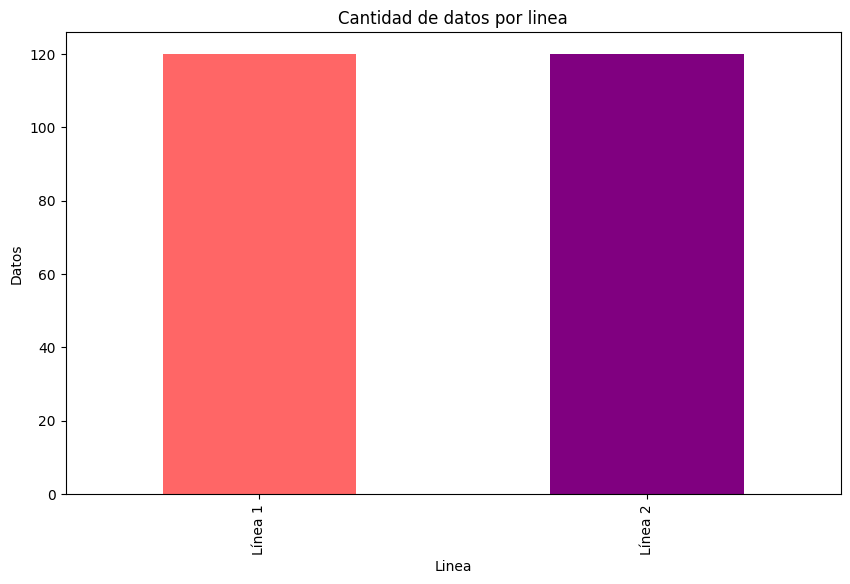

In [349]:

# Diccionario para cada una de las lineas
colores_lineas = {'Línea 1': '#FF6666', 'Línea 2': 'purple'}

#visualizacion de cantidad de datos por linea
plt.figure(figsize=(10,6))
conteo.plot(kind="bar",color=colores_lineas.values())
plt.title("Cantidad de datos por linea")
plt.xlabel("Linea")
plt.ylabel("Datos")
plt.show()


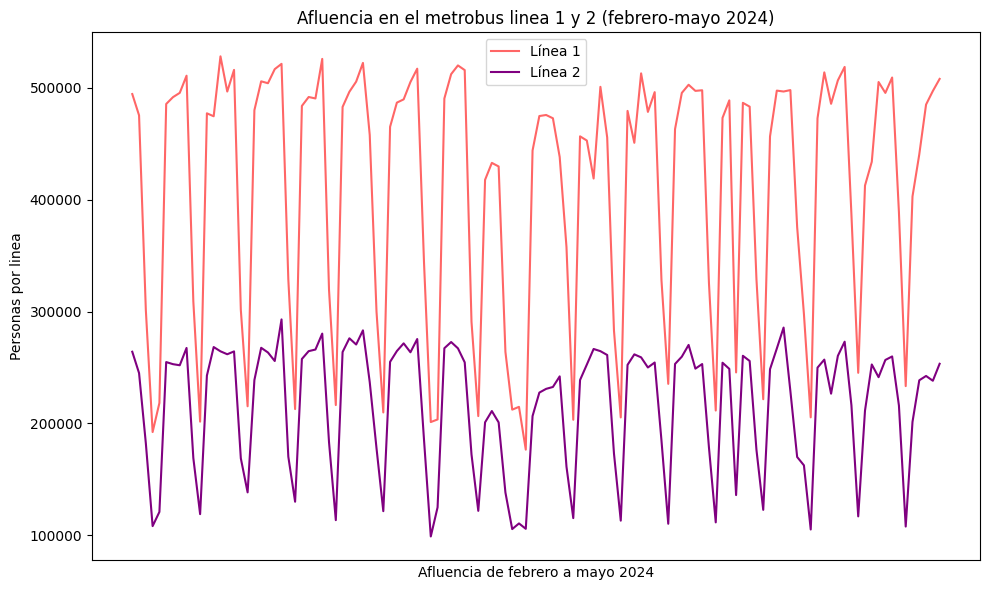

In [350]:
# Gráfico de líneas (1 y 2)
plt.figure(figsize=(10, 6))
plt.plot(df_linea1['fecha'], df_linea1['afluencia_total'], label='Línea 1',color="#FF6666")
plt.plot(df_linea2['fecha'], df_linea2['afluencia_total'], label='Línea 2',color="purple")

# Configuracion el gráfico
plt.title('Afluencia en el metrobus linea 1 y 2 (febrero-mayo 2024)')#titulo
plt.ylabel('Personas por linea')#etiqueta del eje y
plt.xlabel('Afluencia de febrero a mayo 2024')#etiqueta del eje x
plt.xticks([])  #Se elimina todas las etiquetas del eje X
plt.legend()  # Muestra la leyenda para distinguir entre líneas
plt.tight_layout()  # Ajusta el espacio entre elementos del gráfico
plt.show()#Muestra el grafico

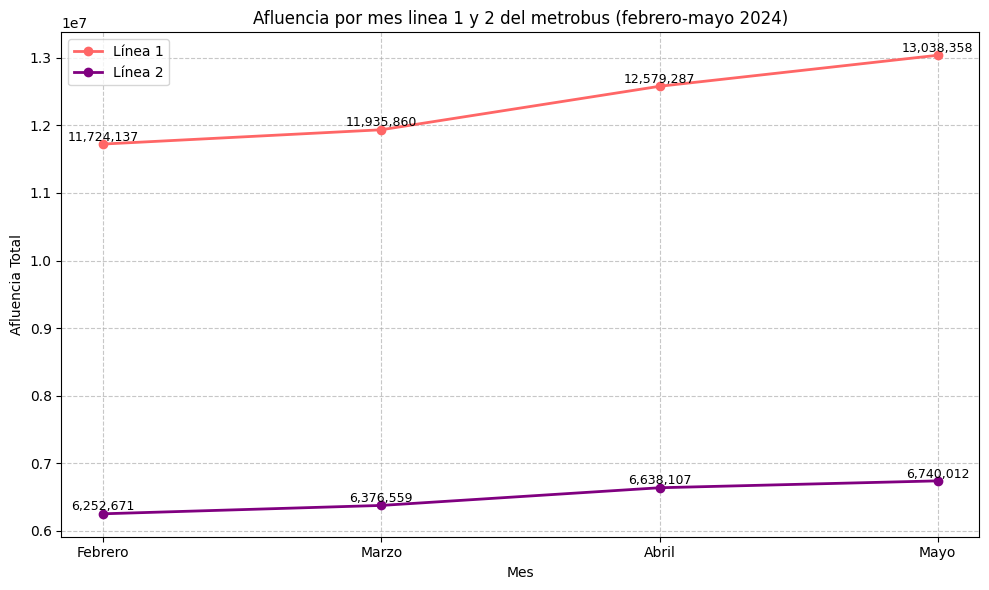

In [351]:
# Orden en base al mes (febrero a mayo 2024)
df_mes = df_nuevo.groupby(['mes', 'linea'], as_index=False)['afluencia_total'].sum()
orden_meses = ['Febrero', 'Marzo', 'Abril', 'Mayo']
df_mes['mes'] = pd.Categorical(df_mes['mes'], categories=orden_meses, ordered=True)

# Df para cada una de las lineas
df_linea1_af = df_mes[df_mes['linea'] == 'Línea 1'].sort_values('mes')
df_linea2_af = df_mes[df_mes['linea'] == 'Línea 2'].sort_values('mes')



# Tamaño del grafico
plt.figure(figsize=(10, 6))

# Orden de los meses para eje x
x = range(len(orden_meses))  # Posiciones 0,1,2,3 correspondientes a los meses

# Linea 1
plt.plot(x, df_linea1_af['afluencia_total'],
         label='Línea 1', #Etiqueta
         color=colores_lineas['Línea 1'], #Color rojo para la linea 1
         marker='o',#Circulo  en el mes correspondiente
         linewidth=2)#Grosor de la linea

# Linea 2
plt.plot(x, df_linea2_af['afluencia_total'],
         label='Línea 2',#Etiqueta
         color=colores_lineas['Línea 2'],  #Color rojo para la linea 2
         marker='o',#Circulo  en el mes correspondiente
         linewidth=2)#Grosor de la linea

# Etiquetas para mostrar  la afluencia por mes
for i, val in enumerate(df_linea1_af['afluencia_total']):
    plt.text(i, val + 5000, f"{val:,}", ha='center', va='bottom', fontsize=9)

for i, val in enumerate(df_linea2_af['afluencia_total']):
    plt.text(i, val + 5000, f"{val:,}", ha='center', va='bottom', fontsize=9)

# Configuración del gráfico
plt.title('Afluencia por mes linea 1 y 2 del metrobus (febrero-mayo 2024)')
plt.xlabel('Mes')
plt.ylabel('Afluencia Total')
plt.xticks(x, orden_meses)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()

# Mostrar
plt.show()

En terminos generales y antes de entrar a los estadisticos descriptivos podemos observar que a lo largo de los meses de febrero a mayo del 2024 la afluencia en la linea 1 es mayor(aproximadamente el doble) que en la linea 2 y que existe un aumento en el mes de mayo en ambas lineas

In [352]:
#Descriptivos en base a la linea
descriptivos = df_nuevo.groupby('linea')['afluencia_total'].describe()
descriptivos



,count,mean,std,min,25%,50%,75%,max
linea,,,,,,,,
Línea 1,120.0,410647.016667,113024.496318,176589.0,316837.0,473087.5,496815.25,528289.0
Línea 2,120.0,216727.908333,57508.797512,98966.0,172913.5,243921.5,261362.75,293031.0


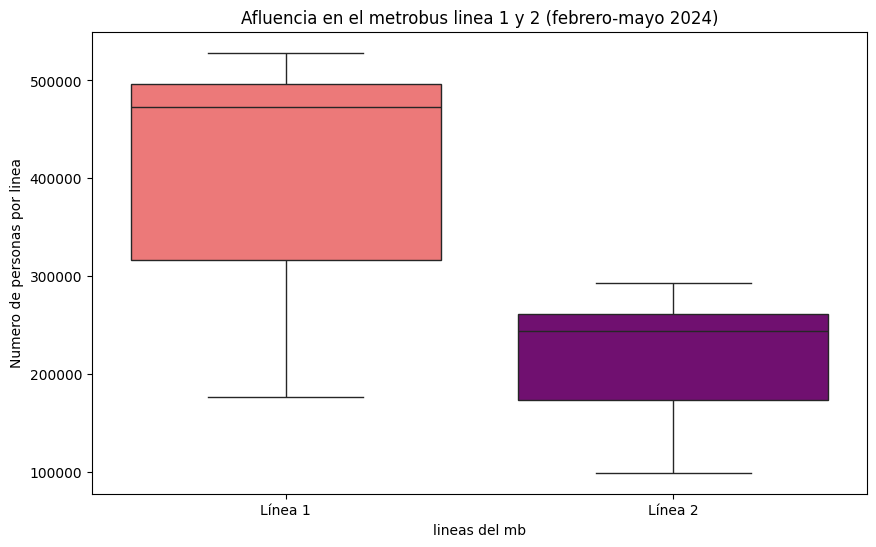

In [353]:
# Caja de bigotes para ver la afluencia por linea
plt.figure(figsize=(10, 6))
sns.boxplot(data=df_nuevo, x='linea', y='afluencia_total', hue='linea', palette=['#FF6666', 'purple'], legend=False)

# Configuracion del gráfico
plt.title("Afluencia en el metrobus linea 1 y 2 (febrero-mayo 2024)")
plt.xlabel("lineas del mb")
plt.ylabel('Numero de personas por linea')
plt.show()


Para la **linea 1** encontramos un media de **411,522** y una mediana de **473,268**, con valores mas cercanos al tercer cuartil **496,831** lo que nos indica un sesgo a la izquierda, indicando que pueden existir mayor concentracion de datos a la derecha, tambien tenemos una desviacion estandar de **112,963** lo cual se puede interpretar como una variablidad general considerable entre los datos


Para la **linea 2** encontramos un media de **217,151** y una mediana de **245,044**, con valores mas cercanos al tercer cuartil **261,791** lo que nos indica un sesgo a la izquierda, indicando que pueden existir mayor concentracion de datos a la derecha, tambien tenemos una desviacion estandar de **57,458** lo cual se puede interpretar como una variablidad general considerable entre los datos






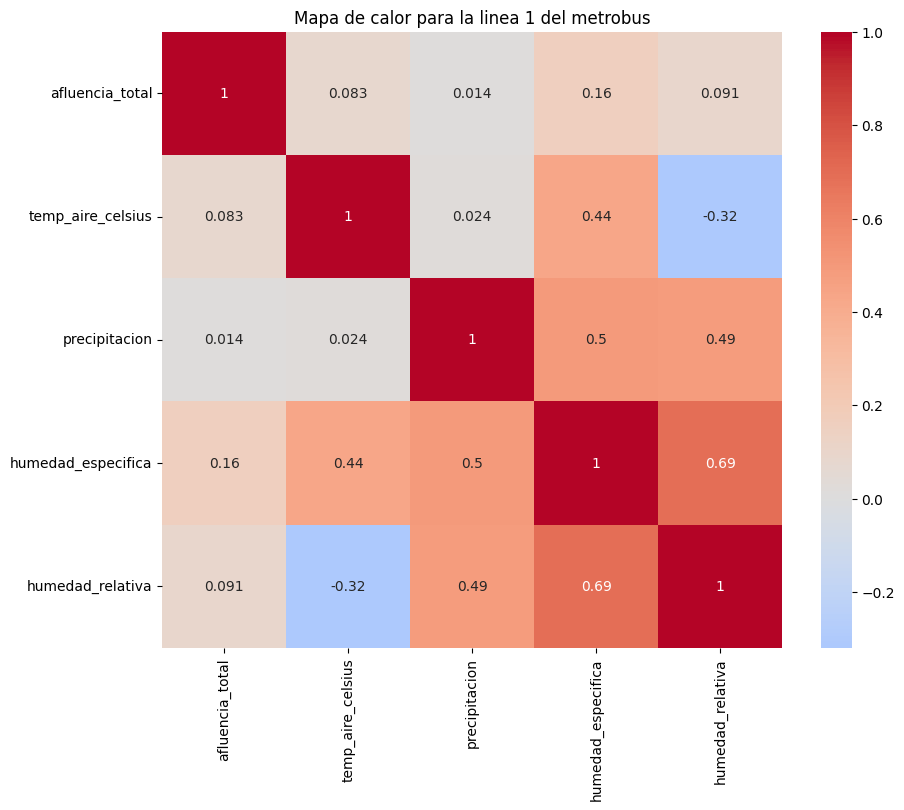

In [354]:
#MAPA DE CALOR PARA LA LINEA 1 DEL METROBUS DE LA CDMX
# Selecciona de columnas
columnas_numericas = df_linea1.select_dtypes(include=['int64', 'float64'])
# Eliminacion de la columna anio, debido a que solo muestra el año de los datos(es decir 2024)
columnas_numericas= columnas_numericas.drop(columns=['anio',"..anio_fecha"], errors='ignore')  # 'errors='ignore'' evita errores si la columna no existe

# Calcula la matriz de correlación
corr_matrix = columnas_numericas.corr()

# Visualiza la matriz de correlación

# Heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0)
plt.title("Mapa de calor para la linea 1 del metrobus")
plt.show()

Encontramos una correlacion baja entre la afluencia total y las variables climatologicas para la linea 1 del metrobus de la cdmx

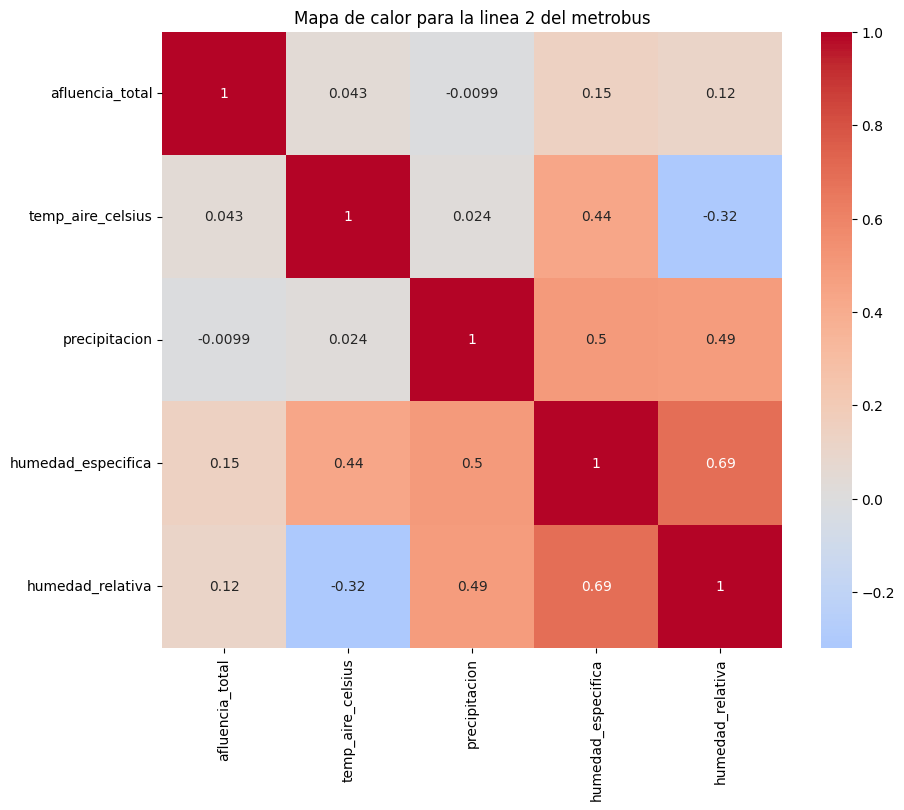

In [355]:
#MAPA DE CALOR PARA LA LINEA 2 DEL METROBUS DE LA CDMX
# Selecciona de columnas tipo int and float
columnas_numericas = df_linea2.select_dtypes(include=['int64', 'float64'])
# Eliminacion de la columna anio, debido a que solo muestra el año de los datos(es decir 2024)
columnas_numericas= columnas_numericas.drop(columns=['anio',"..anio_fecha"], errors='ignore')  # 'errors='ignore'' evita errores si la columna no existe

# Calcula la matriz de correlación
corr_matrix = columnas_numericas.corr()

# Visualiza la matriz de correlación

# Heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0)
plt.title("Mapa de calor para la linea 2 del metrobus")
plt.show()

Encontramos una correlacion baja entre la afluencia total y las variables climatologicas para la linea 2 del metrobus de la cdmx

#SECCIONAMIENTO DE LOS DATOS/INGENIERIA DE LAS CARACTERISTICAS

In [356]:
#traformacion de object a .dt
df['fecha'] = pd.to_datetime(df['fecha'])
df_nuevo['fecha'] = pd.to_datetime(df_nuevo['fecha'])
df_linea1['fecha'] = pd.to_datetime(df_linea1['fecha'])
df_linea2['fecha'] = pd.to_datetime(df_linea2['fecha'])


In [357]:
# Funcion para clasificar el tipo de dia
def dias_xgboost(df, year=2024):
    # Columna tipo_dia con valores por defecto
    df['tipo_dia'] = np.where(df['fecha'].dt.dayofweek < 5, 'Entre Semana', 'Fin de Semana')

    # Feriados del 2024 y 2025
    feriados = pd.to_datetime(['2024-02-05', '2024-03-18', '2024-05-01']) if year == 2024 else \
               pd.to_datetime(['2025-02-03', '2025-03-17', '2025-05-01'])

    # Dia feriado aplicado para que se pueda distinguir
    df.loc[df['fecha'].isin(feriados), 'tipo_dia'] = 'Feriado'

    # Extraer características de dia de la semana y del mes
    df['dia_semana'] = df['fecha'].dt.dayofweek  #Se ve representado el dia de la semana de 0 a 6 donde 0 es lunes y asi sucesivamente
    df['dia_mes'] = df['fecha'].dt.day

    # Uso de dummies
    dummies = pd.get_dummies(df['tipo_dia'], prefix='tipo_dia')

    # Concatenar dummies y eliminar columna original
    df_final = pd.concat([df.drop(columns=['tipo_dia']), dummies], axis=1)

    return df_final

# Aplicacion la función a cada df
df_linea1 = dias_xgboost(df_linea1, year=2024).reset_index(drop=True)
df_linea2= dias_xgboost(df_linea2, year=2024).reset_index(drop=True)




Aplicacion de one hot encoding para tipo_dia y para dia_semana y dia_mes se le extrajo el dia y el mes respectivamente

In [358]:
#Df con los tipos de dia para la linea 1
df_linea1.head()


,fecha,linea,mes,anio,temporal_fecha,..anio_fecha,afluencia_total,temp_aire_celsius,precipitacion,humedad_especifica,humedad_relativa,dia_semana,dia_mes,tipo_dia_Entre Semana,tipo_dia_Feriado,tipo_dia_Fin de Semana
0,2024-02-01,Línea 1,Febrero,2024,2024-02,2024,494567,11.26,0.1,6.75,62.22,3,1,True,False,False
1,2024-02-02,Línea 1,Febrero,2024,2024-02,2024,475543,11.96,0.0,6.87,65.43,4,2,True,False,False
2,2024-02-03,Línea 1,Febrero,2024,2024-02,2024,301361,10.47,0.0,6.42,66.60,5,3,False,False,True
3,2024-02-04,Línea 1,Febrero,2024,2024-02,2024,192326,10.29,0.0,3.41,42.31,6,4,False,False,True
4,2024-02-05,Línea 1,Febrero,2024,2024-02,2024,218310,10.02,0.0,2.89,31.92,0,5,False,True,False


In [359]:
#Df con los tipos de dia para la linea 2
df_linea2.head()

,fecha,linea,mes,anio,temporal_fecha,..anio_fecha,afluencia_total,temp_aire_celsius,precipitacion,humedad_especifica,humedad_relativa,dia_semana,dia_mes,tipo_dia_Entre Semana,tipo_dia_Feriado,tipo_dia_Fin de Semana
0,2024-02-01,Línea 2,Febrero,2024,2024-02,2024,264127,11.26,0.1,6.75,62.22,3,1,True,False,False
1,2024-02-02,Línea 2,Febrero,2024,2024-02,2024,245044,11.96,0.0,6.87,65.43,4,2,True,False,False
2,2024-02-03,Línea 2,Febrero,2024,2024-02,2024,182256,10.47,0.0,6.42,66.60,5,3,False,False,True
3,2024-02-04,Línea 2,Febrero,2024,2024-02,2024,108203,10.29,0.0,3.41,42.31,6,4,False,False,True
4,2024-02-05,Línea 2,Febrero,2024,2024-02,2024,120915,10.02,0.0,2.89,31.92,0,5,False,True,False


In [360]:
#Columnas
print(df_linea1.columns)
print(df_linea2.columns)

Index(['fecha', 'linea', 'mes', 'anio', 'temporal_fecha', '..anio_fecha',
       'afluencia_total', 'temp_aire_celsius', 'precipitacion',
       'humedad_especifica', 'humedad_relativa', 'dia_semana', 'dia_mes',
       'tipo_dia_Entre Semana', 'tipo_dia_Feriado', 'tipo_dia_Fin de Semana'],
      dtype='object')
Index(['fecha', 'linea', 'mes', 'anio', 'temporal_fecha', '..anio_fecha',
       'afluencia_total', 'temp_aire_celsius', 'precipitacion',
       'humedad_especifica', 'humedad_relativa', 'dia_semana', 'dia_mes',
       'tipo_dia_Entre Semana', 'tipo_dia_Feriado', 'tipo_dia_Fin de Semana'],
      dtype='object')


In [361]:
#Frecuencia de tipo de dia para la linea 1
frecuencias_tipo_dia_linea1 = {
    'Entre Semana': df_linea1['tipo_dia_Entre Semana'].sum(),
    'Feriado': df_linea1['tipo_dia_Feriado'].sum(),
    'Fin de Semana': df_linea1['tipo_dia_Fin de Semana'].sum()
}

print("Frecuencia por cada tipo de dia df_linea1:")
for tipo, freq in frecuencias_tipo_dia_linea1.items():
    print(f"{tipo}: {int(freq)}")



Frecuencia por cada tipo de dia df_linea1:
Entre Semana: 83
Feriado: 3
Fin de Semana: 34


In [362]:
#Frecuencia de tipo de dia para la linea 2
frecuencias_tipo_dia_linea2 = {
    'Entre Semana': df_linea2['tipo_dia_Entre Semana'].sum(),
    'Feriado': df_linea2['tipo_dia_Feriado'].sum(),
    'Fin de Semana': df_linea2['tipo_dia_Fin de Semana'].sum()
}

print("Frecuencia por cada tipo de dia df_linea2:")
for tipo, freq in frecuencias_tipo_dia_linea2.items():
    print(f"{tipo}: {int(freq)}")



Frecuencia por cada tipo de dia df_linea2:
Entre Semana: 83
Feriado: 3
Fin de Semana: 34


In [363]:
#funcion para graficas de frecuencia en base al tipo de dia

def grafica_frecuencia(df, nombre_df):
    # Suma cada columna para observar la frecuencia
    frecuencias = {
        'Entre Semana': df['tipo_dia_Entre Semana'].sum(),
        'Fin de Semana': df['tipo_dia_Fin de Semana'].sum(),
        'Feriado': df['tipo_dia_Feriado'].sum()

    }

    # Se convierten en series para que sea mas sencillo graficar
    frecuencias_series = pd.Series(frecuencias)

    # Grafica
    plt.figure(figsize=(8, 6))
    frecuencias_series.plot(kind='bar', color=plt.cm.Set3(np.linspace(0, 1, len(frecuencias_series))))
    plt.title(f"Frecuencia por Tipo de Día en {nombre_df}")
    plt.xlabel("Tipo de Día")
    plt.ylabel("Frecuencia")
    plt.xticks(rotation=0)
    plt.show()


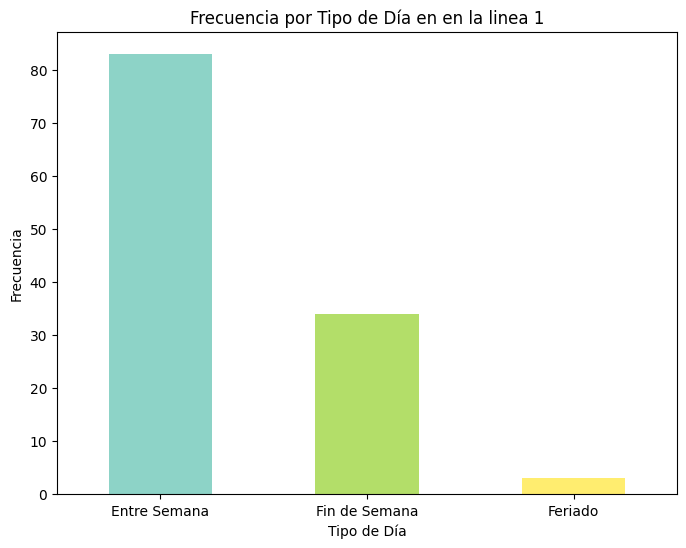

In [364]:
grafica_frecuencia(df_linea1, "en la linea 1")

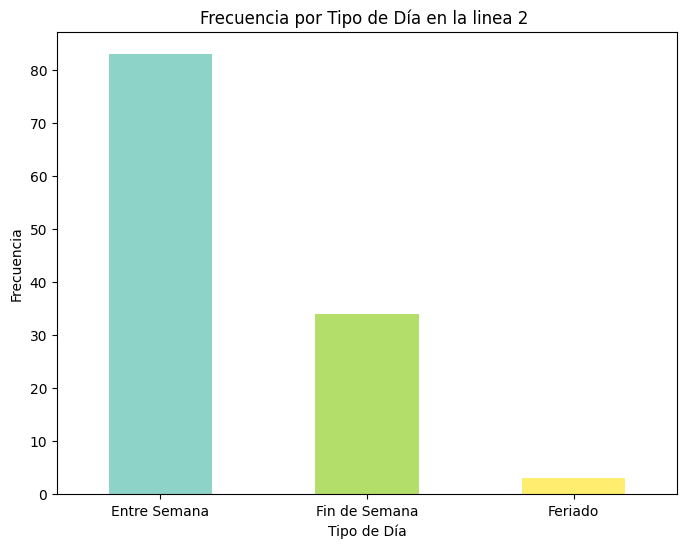

In [365]:
grafica_frecuencia(df_linea2, "la linea 2 ")

In [366]:
#Funcion para ver la afluencia en base al tipo de dia
def grafica_afluencia_simple(df, nombre_df):
    # Elegimos las columnas para ver la afluencia en base al tipo de dia
    cols_tipo = ['tipo_dia_Entre Semana', 'tipo_dia_Fin de Semana','tipo_dia_Feriado']

    # Transformar columnas dummy
    df_melt = pd.melt(df, id_vars=['afluencia_total'], value_vars=cols_tipo,
                      var_name='tipo_dia', value_name='es_tipo')

    # Filtrar filas
    df_melt = df_melt[df_melt['es_tipo'] == 1].copy()

    # Limpiar nombres de tipo_dia para que sean legibles
    df_melt['tipo_dia'] = df_melt['tipo_dia'].str.replace('tipo_dia_', '')

    # Graficar boxplot
    plt.figure(figsize=(8, 6))
    sns.boxplot(x='tipo_dia', y='afluencia_total', data=df_melt, hue='tipo_dia', palette='Set2', showfliers=False,legend=False)
    plt.title(f"Afluencia por tipo de día en {nombre_df}")
    plt.xlabel("Tipo de Día")
    plt.ylabel("Afluencia Total")
    plt.show()

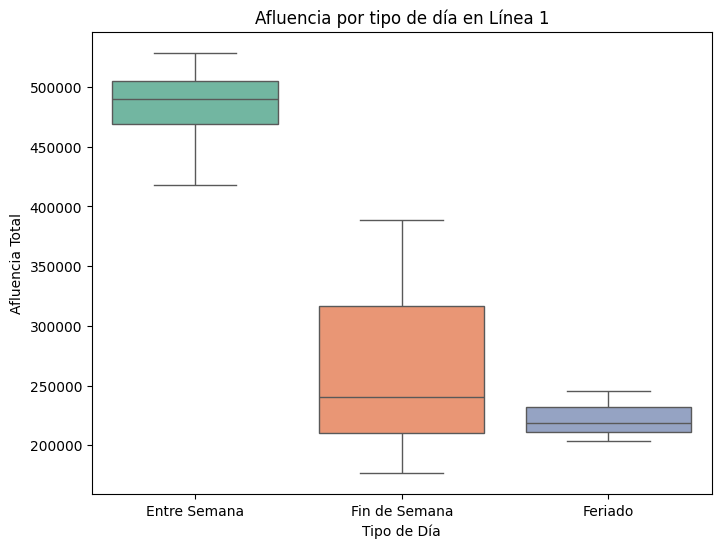

In [367]:
grafica_afluencia_simple(df_linea1, "Línea 1")

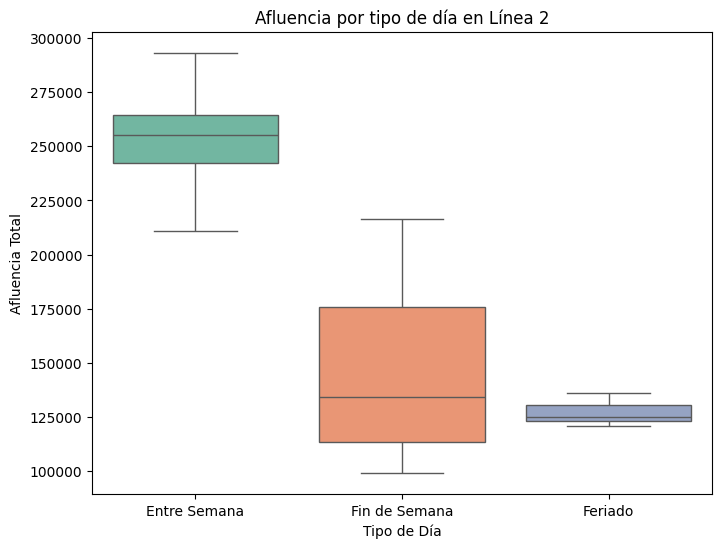

In [368]:
grafica_afluencia_simple(df_linea2, "Línea 2")

In [369]:
def estadisticos_tipo_dia(df, nombre_linea):


    print(f"Estadísticos por tipo de día - {nombre_linea}")

    # Columna categorica temporal combinando las dummies
    condiciones = [
        df['tipo_dia_Entre Semana'] == 1,
        df['tipo_dia_Fin de Semana'] == 1,
        df['tipo_dia_Feriado'] == 1
    ]
    opciones = ['Entre Semana', 'Fin de Semana', 'Feriado']

    df['tipo_dia'] = np.select(condiciones, opciones, default='Otro')

    # 2. Calcular estadísticos con describe()
    estadisticos = df.groupby('tipo_dia')['afluencia_total'].describe()

    # 4. Eliminar columna temporal (opcional)
    df.drop('tipo_dia', axis=1, inplace=True)

    return estadisticos



In [370]:
estadisticos_tipo_dia(df_linea1, "Línea 1")

Estadísticos por tipo de día - Línea 1


,count,mean,std,min,25%,50%,75%,max
tipo_dia,,,,,,,,
Entre Semana,83.0,477213.469880,48667.735880,212350.0,469080.50,489805.0,504786.0,528289.0
Feriado,3.0,222502.333333,21339.624091,203570.0,210940.00,218310.0,231968.5,245627.0
Fin de Semana,34.0,264747.558824,62113.292796,176589.0,210269.25,240338.0,316837.0,389015.0


**AFLUENCIA DE LA LINEA 1 DEL METROBUS**

**Dias entre semana**

El promedio es de 477,681, la mediana es de 490,198 y la desviación estándar es de 48,563 , el valor mínimo 212,350 y el máximo 528,289 lo que sugiere que durante los días entre semana hay una alta actividad en comparacion a los demas tipos de dias,con respecto a la desviacion estandar se ve algo de variabilidad pero sin ser extremo

**Feriado**

El promedio es de 222,502, la mediana es de 218,310 y la desviación estándar es de	21,339, el valor mínimo 203,570 y el máximo 245,627, lo que sugiere que los dias festivos tienen una actividad estable sin embargo al ser pocos datos la informacion puede verse



**Fin de semana**

El promedio es de 264,747, la mediana es de 240,338,la desviación estándar es de 62,113, el valor mínimo 176,589 y el máximo 389,015  lo que sugiere que existe una variabilidad moderada y la existencia de sesgo hacia valores mas altos



In [371]:
estadisticos_tipo_dia(df_linea2, "Línea 2")

Estadísticos por tipo de día - Línea 2


,count,mean,std,min,25%,50%,75%,max
tipo_dia,,,,,,,,
Entre Semana,83.0,249116.289157,29049.535301,105543.0,242292.00,255088.0,264655.5,293031.0
Feriado,3.0,127290.666667,7780.339731,120915.0,122956.00,124997.0,130478.5,135960.0
Fin de Semana,34.0,145553.676471,35224.135973,98966.0,113196.25,134194.5,175621.0,216214.0


**AFLUENCIA DE LA LINEA 2 DEL METROBUS**

**Dias entre semana**
El promedio es de 249,341, la mediana es de 255,465, la desviación estándar es de 28,947, el valor mínimo es 105,543 y el máximo es 293,031.
Esto sugiere que, aunque el uso promedio es alto, hay días de la semana con una afluencia significativamente menor.



**Fin de semana**
El promedio es de 145,554, la mediana es de 134,194, la desviación estándar es de 35,224, el valor mínimo es 98,966 y el máximo es 216,214.

**Feriado**
 El promedio es de 127,291, la mediana es de 124,997, la desviación estándar es de 7,780, el valor mínimo es 120,915 y el máximo es 135,960,lo que indica una variabilidad moderada.

RECUERDA AL FINAL ADJUNTAR LOS ARCHIVOS QUE USASTE EN TU DRIVE LA CARPETA SE LLAMA datosgeograficos y ahi viene el archivo que debes adjuntar

#RUTA ZIP Y GEOJSON DE LA LINEA 1 Y 2 DEL MB DE LA CDMX

In [372]:
#Se asigna la ruta zip donde tenemos los datos geograficos
#ruta_zip = "/content/drive/My Drive/Ciencia de datos/Proyecto final/datosgeograficos/datosgeomblinea1y2.zip"
ruta_zip= "datosgeomblinea1y2.zip"

In [373]:
#ruta_zip = "/content/drive/My Drive/Ciencia de datos/Proyecto final/datosgeograficos/datosgeomblinea1y2.zip" #ruta donde estan los datos
ruta_destino = "/content/datos_geojson"

# Carpeta destino
os.makedirs(ruta_destino, exist_ok=True)

# Extraer ZIP
with zipfile.ZipFile(ruta_zip, 'r') as zip_ref:
    zip_ref.extractall(ruta_destino)


In [374]:
#Verificar si estan los archivos
print(os.listdir(ruta_destino))


['Metrobus_estaciones.json', 'Metrobus_lineas.json']


In [375]:
#Funcion para poder cargar los archivos
def cargar_datos_geojson(ruta_base="/content/datos_geojson"):
    archivo_estaciones = os.path.join(ruta_base, "Metrobus_estaciones.json")
    archivo_lineas = os.path.join(ruta_base, "Metrobus_lineas.json")

    if not os.path.exists(archivo_estaciones):
        raise FileNotFoundError(f"No se encontró: {archivo_estaciones}")
    if not os.path.exists(archivo_lineas):
        raise FileNotFoundError(f"No se encontró: {archivo_lineas}")

    estaciones = gpd.read_file(archivo_estaciones)
    lineas = gpd.read_file(archivo_lineas)
    return estaciones, lineas


In [376]:
# Cargar los archivos
estacionesmblinea1y2, lineasmb1y2 = cargar_datos_geojson()

#Primeros 5 datos de las estaciones
print(estacionesmblinea1y2.head())

    SISTEMA            NOMBRE LINEA EST CVE_EOD17        TIPO  \
0  Metrobús  Dep. 18 de Marzo    01  02     11013  Transbordo   
1  Metrobús           Eúzkaro    01  03     11018  Intermedia   
2  Metrobús           Potrero    01  04     11038  Intermedia   
3  Metrobús           La Raza    01  05     11029  Transbordo   
4  Metrobús          Circuito    01  06     11008  Transbordo   

           ALCALDIAS     AÑO CVE_EST                        geometry  
0  Gustavo A. Madero  2005.0  MB0102  POINT Z (-99.12453 19.48629 0)  
1  Gustavo A. Madero  2005.0  MB0103  POINT Z (-99.12763 19.48252 0)  
2  Gustavo A. Madero  2005.0  MB0104  POINT Z (-99.13247 19.47664 0)  
3  Gustavo A. Madero  2005.0  MB0105   POINT Z (-99.13899 19.4687 0)  
4         Cuauhtémoc  2005.0  MB0106  POINT Z (-99.14401 19.46261 0)  


In [377]:
#Primeros 5 datos de las lineas
print(lineasmb1y2.head())

    SISTEMA                           RUTA  \
0  Metrobús    Indios Verdes - El Caminero   
1  Metrobús    Indios Verdes - Insurgentes   
2  Metrobús  Indios Verdes - Doctor Gálvez   
3  Metrobús       Buenavista - El Caminero   
4  Metrobús          Tepalcates - Tacubaya   

                                              TRAMO LINEA  \
0                       Indios Verdes - El Caminero    01   
1                       Indios Verdes - Insurgentes    01   
2                     Indios Verdes - Doctor Gálvez    01   
3                          Buenavista - El Caminero    01   
4  Circuito Constitución de Apatzingán - Tepalcates    02   

                                            geometry  
0  LINESTRING (-99.11972 19.49682, -99.11961 19.4...  
1  LINESTRING (-99.11972 19.49682, -99.11961 19.4...  
2  LINESTRING (-99.11972 19.49682, -99.11961 19.4...  
3  LINESTRING (-99.15207 19.44641, -99.15256 19.4...  
4  LINESTRING (-99.05985 19.38903, -99.05974 19.3...  


In [378]:
#Columnas de las estaciones y de las columnas
print(estacionesmblinea1y2.columns)
print(lineasmb1y2.columns)

Index(['SISTEMA', 'NOMBRE', 'LINEA', 'EST', 'CVE_EOD17', 'TIPO', 'ALCALDIAS',
       'AÑO', 'CVE_EST', 'geometry'],
      dtype='object')
Index(['SISTEMA', 'RUTA', 'TRAMO', 'LINEA', 'geometry'], dtype='object')




#MAPA DE LA CDMX CON LINEA 1 Y 2 DEL MB

In [379]:
#Estaciones de cada linea
print("Estaciones Línea 1:", estacionesmblinea1y2[estacionesmblinea1y2['LINEA'] == '01']['NOMBRE'].unique())#Estaciones de la linea 1
print("Estaciones Línea 2:", estacionesmblinea1y2[estacionesmblinea1y2['LINEA'] == '02']['NOMBRE'].unique()) #Estaciones de la linea 2


Estaciones Línea 1: ['Dep. 18 de Marzo' 'Eúzkaro' 'Potrero' 'La Raza' 'Circuito' 'San Simón'
 'Manuel González' 'Buenavista' 'El Chopo' 'Revolución'
 'Plaza de la República' 'Reforma' 'Hamburgo' 'Insurgentes' 'Durango'
 'Álvaro Obregón' 'Sonora' 'Campeche' 'Chilpancingo' 'Nuevo León'
 'La Piedad' 'Polifórum' 'Nápoles' 'Colonia del Valle'
 'Cd. de los Deportes' 'Parque Hundido' 'Félix Cuevas' 'Río Churubusco'
 'Teatro de los Insurgentes' 'José María Velasco' 'Francia' 'Olivo'
 'Altavista' 'La Bombilla' 'Doctor Gálvez' 'Cd. Universitaria' 'C.C.U.'
 'Perisur' 'Villa Olímpica' 'Corregidora' 'Ayuntamiento'
 'Fuentes Brotantes' 'Santa Úrsula' 'La Joya' 'El Caminero'
 'Indios Verdes' 'Buenavista II']
Estaciones Línea 2: ['Tacubaya' 'Parque Lira' 'Antonio Maceo' 'De la Salle' 'Patriotismo'
 'Escandón' 'Nuevo León' 'Viaducto' 'Amores' 'Etiopía' 'Doctor Vértiz'
 'Centro SCOP' 'Álamos' 'Xola' 'Las Américas' 'Andrés Molina Enríquez'
 'La Viga' 'Coyuya' 'Metro Coyuya' 'Canela' 'Tlacotal' 'Goma' 'Iz

In [380]:
#Columnas de las estaciones,
print("Columnas de estacionesmblinea1y2:", estacionesmblinea1y2.columns.tolist())
print("Columnas de df_nuevo:", df_nuevo.columns.tolist())

Columnas de estacionesmblinea1y2: ['SISTEMA', 'NOMBRE', 'LINEA', 'EST', 'CVE_EOD17', 'TIPO', 'ALCALDIAS', 'AÑO', 'CVE_EST', 'geometry']
Columnas de df_nuevo: ['fecha', 'linea', 'mes', 'anio', 'temporal_fecha', '..anio_fecha', 'afluencia_total']


In [381]:
#MAPA COMPLETO CON LAS ESTACIONES

In [382]:
#Estaciones por linea
estaciones_por_linea = {
   '01': ["Indios Verdes","Dep. 18 de Marzo","Eúzkaro","Potrero","La Raza","Circuito","San Simón",
           "Manuel González","Buenavista","El Chopo","Revolución","Plaza de la República","Reforma","Hamburgo",
           "Insurgentes","Durango","Álvaro Obregón","Sonora","Campeche","Chilpancingo","Nuevo León","La Piedad",
           "Polifórum","Nápoles","Colonia del Valle","Ciudad de los Deportes","Parque Hundido","Félix Cuevas",
           "Río Churubusco","Teatro de los Insurgentes","José María Velasco","Francia","Olivo","Altavista","La Bombilla",
           "Doctor Gálvez","Ciudad Universitaria","C.C.U.","Perisur","Villa Olímpica","Corregidora","Ayuntamiento",
           "Fuentes Brotantes","Santa Úrsula","La Joya","El Caminero"],
     '02': ["Tacubaya","Parque Lira" "Antonio Maceo", "De la Salle", "Patriotismo", "Escandón", "Nuevo León", "Viaducto",
            "Amores", "Etiopía", "Doctor Vértiz", "Centro SCOP", "Álamos", "Xola", "Las Américas",
            "Andrés Molina Enríquez", "La Viga", "Coyuya", "Metro Coyuya", "Canela", "Tlacotal", "Goma", "Iztacalco",
            "UPIICSA", "El Rodeo", "Río Tecolutla","Río Mayo","Rojo Gómez", "Río Frío","Leyes de Reforma", 'Del Moral',
            "CCH Oriente", "Const. de Apatzingán", "Gral. Antonio de León", "Canal de San Juan", "Nicolás Bravo",
            "Tepalcates"]}


# Función para crear líneas desde estaciones
def crear_linea_desde_estaciones(linea):
    coords = []
    for nombre_estacion in estaciones_por_linea[linea]:
        estacion = estacionesmblinea1y2[estacionesmblinea1y2['NOMBRE'] == nombre_estacion.strip()]
        if not estacion.empty:
            coords.append((estacion.iloc[0].geometry.x, estacion.iloc[0].geometry.y))
    return LineString(coords) if coords else None

# Mapa base
m = folium.Map(location=[19.4326, -99.1332], zoom_start=12)

# Configuracion de los colores
colores = {'01': 'red', '02': 'purple'}

# Añadir líneas directamente al mapa (sin capas separadas)
for linea in ['01', '02']:
    linea_geom = crear_linea_desde_estaciones(linea)
    if linea_geom:
        folium.GeoJson(
            gpd.GeoSeries([linea_geom]).to_json(),
            style_function=lambda x, c=colores[linea]: {
                'color': c,
                'weight': 3,  # Grosor
                'opacity': 0.8
            }
        ).add_to(m)

# Añadir todas las estaciones
for linea in ['01', '02']:
    for nombre in estaciones_por_linea[linea]:
        estacion = estacionesmblinea1y2[estacionesmblinea1y2['NOMBRE'] == nombre.strip()]
        if not estacion.empty:
            folium.CircleMarker(
                location=[estacion.iloc[0].geometry.y, estacion.iloc[0].geometry.x],
                radius=5,
                color=colores[linea],
                fill=True,
                popup=f"{nombre} (Línea {linea})"
            ).add_to(m)

m  # Mapa
#m.save("mapa_lineas_1y2.html")
#files.download("mapa_lineas_1y2.html")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [383]:

# Mapa de la CDMX en las coordenadas
m = folium.Map(location=[19.4326, -99.1332], zoom_start=12)

# Estaciones por linea
estaciones_por_linea = {
    '01': ["Indios Verdes","Dep. 18 de Marzo","Eúzkaro","Potrero","La Raza","Circuito","San Simón",
           "Manuel González","Buenavista","El Chopo","Revolución","Plaza de la República","Reforma","Hamburgo",
           "Insurgentes","Durango","Álvaro Obregón","Sonora","Campeche","Chilpancingo","Nuevo León","La Piedad",
           "Polifórum","Nápoles","Colonia del Valle","Ciudad de los Deportes","Parque Hundido","Félix Cuevas",
           "Río Churubusco","Teatro de los Insurgentes","José María Velasco","Francia","Olivo","Altavista","La Bombilla",
           "Doctor Gálvez","Ciudad Universitaria","C.C.U.","Perisur","Villa Olímpica","Corregidora","Ayuntamiento",
           "Fuentes Brotantes","Santa Úrsula","La Joya","El Caminero"],
     '02': ["Tacubaya","Parque Lira" "Antonio Maceo", "De la Salle", "Patriotismo", "Escandón", "Nuevo León", "Viaducto",
            "Amores", "Etiopía", "Doctor Vértiz", "Centro SCOP", "Álamos", "Xola", "Las Américas",
            "Andrés Molina Enríquez", "La Viga", "Coyuya", "Metro Coyuya", "Canela", "Tlacotal", "Goma", "Iztacalco",
            "UPIICSA", "El Rodeo", "Río Tecolutla","Río Mayo","Rojo Gómez", "Río Frío", "Leyes de Reforma", 'Del Moral',
            "CCH Oriente", "Const. de Apatzingán", "Gral. Antonio de León", "Canal de San Juan", "Nicolás Bravo",
            "Tepalcates"]}

# 3. Función para crear lineas a partir de las estaciones
def crear_linea_desde_estaciones(linea):
    coords = []
    for nombre_estacion in estaciones_por_linea[linea]:
        estacion = estacionesmblinea1y2[estacionesmblinea1y2['NOMBRE'] == nombre_estacion]
        if not estacion.empty:
            coords.append((estacion.iloc[0].geometry.x, estacion.iloc[0].geometry.y))
    return LineString(coords) if coords else None

# Se ponen los meses en orden
meses = ['Febrero', 'Marzo', 'Abril', 'Mayo']

for mes in meses:
    # Capa por cada mes
    capa_mes = folium.FeatureGroup(name=f'Afluencia 2024 {mes}', show=(mes=='Febrero'))

    # Geometria por linea
    for linea in ['01', '02']:
        linea_geom = crear_linea_desde_estaciones(linea)
        if not linea_geom:
            continue

        # Afluencia por mes para cada una de las lineas
        if linea == '01':
            afluencia = df_linea1_af[df_linea1_af['mes'] == mes]['afluencia_total'].values[0]
        else:
            afluencia = df_linea2_af[df_linea2_af['mes'] == mes]['afluencia_total'].values[0]

        # Grosor para las lineas
        grosor_base = 2 if linea == '01' else 1  #Ajuste del grosor debido a que los datos son diferentes en cantidad de afluencia
        weight = grosor_base + (afluencia / 100000)  # Divide el grosor de la afluencia para que sea mas manejable

        # Color y opacidad
        color = '#e31a1c' if linea == '01' else '#984ea3'

        # Linea al mapa
        folium.GeoJson(
            gpd.GeoSeries([linea_geom]).to_json(),
            style_function=lambda x, c=color, w=weight: {
                'color': c,
                'weight': w,
                'opacity': 0.8
            },
            tooltip=f"Línea {linea} | {mes}<br>Afluencia : {afluencia:,}"
        ).add_to(capa_mes)

    # Se añaden las estaciones
    if mes == 'Febrero':  # Solo las añadimos una vez para evitar duplicados
        for idx, row in estacionesmblinea1y2.iterrows():
            folium.CircleMarker(
                location=[row.geometry.y, row.geometry.x], #ubicacion de las estaciones
                radius=5,
                color='red' if row['LINEA'] == '01' else 'purple', #Color
                fill=True,
                popup=f"{row['NOMBRE']} (Línea {row['LINEA']})" #Para que aparezca el nombre
            ).add_to(m)

    capa_mes.add_to(m)

# 5. Añadir control de capas y leyenda
folium.LayerControl(collapsed=False).add_to(m)

# Mostrar mapa
m


# EDA

In [384]:
#Df linea 1
df_linea1.head()

,fecha,linea,mes,anio,temporal_fecha,..anio_fecha,afluencia_total,temp_aire_celsius,precipitacion,humedad_especifica,humedad_relativa,dia_semana,dia_mes,tipo_dia_Entre Semana,tipo_dia_Feriado,tipo_dia_Fin de Semana
0,2024-02-01,Línea 1,Febrero,2024,2024-02,2024,494567,11.26,0.1,6.75,62.22,3,1,True,False,False
1,2024-02-02,Línea 1,Febrero,2024,2024-02,2024,475543,11.96,0.0,6.87,65.43,4,2,True,False,False
2,2024-02-03,Línea 1,Febrero,2024,2024-02,2024,301361,10.47,0.0,6.42,66.60,5,3,False,False,True
3,2024-02-04,Línea 1,Febrero,2024,2024-02,2024,192326,10.29,0.0,3.41,42.31,6,4,False,False,True
4,2024-02-05,Línea 1,Febrero,2024,2024-02,2024,218310,10.02,0.0,2.89,31.92,0,5,False,True,False


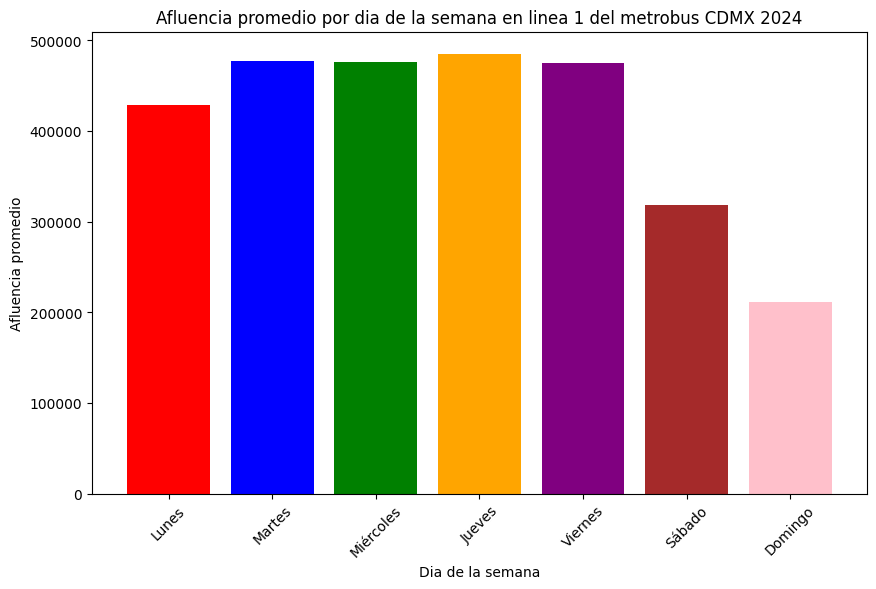

In [385]:
#Promedio de afluencia por dia de la semana en la linea 1 del metrobus

# Media de los dias de la semana por linea
df_barras_linea1 = df_linea1.groupby('dia_semana')['afluencia_total'].mean().reset_index()

#Dias de la semana ordenados
nombres_dias = ['Lunes', 'Martes', 'Miércoles', 'Jueves', 'Viernes', 'Sábado', 'Domingo']
df_barras_linea1['dia_nombre'] = df_barras_linea1['dia_semana'].map(lambda x: nombres_dias[x])

# Grafico de barras
colores = ['red', 'blue', 'green', 'orange', 'purple', 'brown', 'pink']

#Configuracion del grafico
plt.figure(figsize=(10, 6))
plt.bar(df_barras_linea1['dia_nombre'], df_barras_linea1['afluencia_total'], color=colores)
plt.title('Afluencia promedio por dia de la semana en linea 1 del metrobus CDMX 2024')
plt.xlabel('Dia de la semana')
plt.ylabel('Afluencia promedio')
plt.xticks(rotation=45)
plt.grid(False)
plt.show()

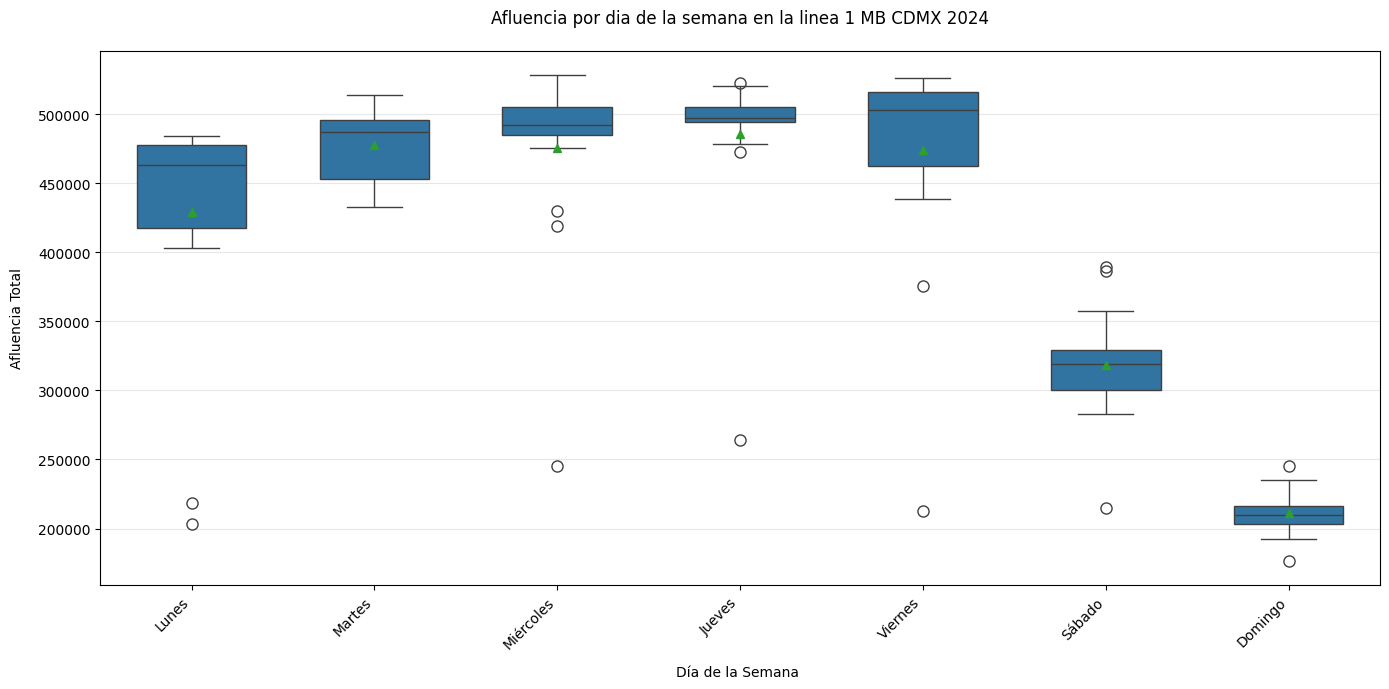

In [386]:
#Diagrama de bigotes para afluencia por dia de la semana para la linea 1

# Configuración de tamaño
plt.figure(figsize=(14, 7))

# Gráfico de caja
sns.boxplot(
    x='dia_semana',
    y='afluencia_total',
    data=df_linea1,
    showmeans=True,  # Media con triangulo verde
    flierprops={'marker': 'o', 'markersize': 8},  # Outliers con un circulo
    width=0.6
)

# Etiquetas para el titulo, eje x y eje y
plt.title('Afluencia por dia de la semana en la linea 1 MB CDMX 2024', pad=20)
plt.xlabel('Día de la Semana ', labelpad=10)
plt.ylabel('Afluencia Total', labelpad=10)

# Etiquetas eje x para dias de la semana
plt.xticks(ticks=range(7), labels=nombres_dias, rotation=45, ha='right')

# Ajustes de espacio
plt.tight_layout()
plt.grid(axis='y', alpha=0.3)
plt.show()

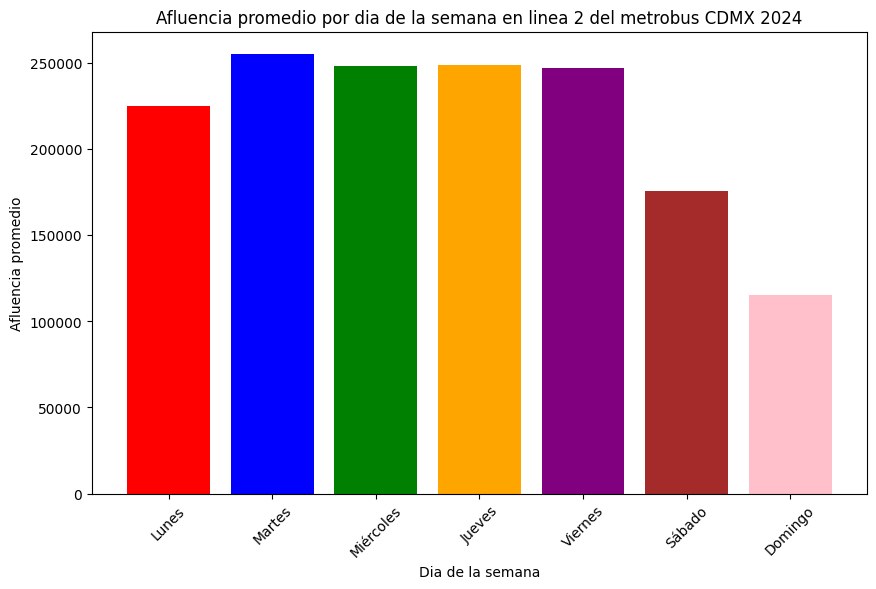

In [387]:
#Promedio de afluencia por dia de la semana en la linea 2 del metrobus

# Media de los dias de la semana por linea
df_barras_linea2 = df_linea2.groupby('dia_semana')['afluencia_total'].mean().reset_index()

#Dias de la semana ordenados
nombres_dias = ['Lunes', 'Martes', 'Miércoles', 'Jueves', 'Viernes', 'Sábado', 'Domingo']
df_barras_linea2['dia_nombre'] = df_barras_linea2['dia_semana'].map(lambda x: nombres_dias[x])

# Grafico de barras
colores = ['red', 'blue', 'green', 'orange', 'purple', 'brown', 'pink']

#Configuracion del grafico
plt.figure(figsize=(10, 6))
plt.bar(df_barras_linea2['dia_nombre'], df_barras_linea2['afluencia_total'], color=colores)
plt.title('Afluencia promedio por dia de la semana en linea 2 del metrobus CDMX 2024')
plt.xlabel('Dia de la semana')
plt.ylabel('Afluencia promedio')
plt.xticks(rotation=45)
plt.grid(False)
plt.show()

In [388]:
#Df linea 2
df_linea2.head()

,fecha,linea,mes,anio,temporal_fecha,..anio_fecha,afluencia_total,temp_aire_celsius,precipitacion,humedad_especifica,humedad_relativa,dia_semana,dia_mes,tipo_dia_Entre Semana,tipo_dia_Feriado,tipo_dia_Fin de Semana
0,2024-02-01,Línea 2,Febrero,2024,2024-02,2024,264127,11.26,0.1,6.75,62.22,3,1,True,False,False
1,2024-02-02,Línea 2,Febrero,2024,2024-02,2024,245044,11.96,0.0,6.87,65.43,4,2,True,False,False
2,2024-02-03,Línea 2,Febrero,2024,2024-02,2024,182256,10.47,0.0,6.42,66.60,5,3,False,False,True
3,2024-02-04,Línea 2,Febrero,2024,2024-02,2024,108203,10.29,0.0,3.41,42.31,6,4,False,False,True
4,2024-02-05,Línea 2,Febrero,2024,2024-02,2024,120915,10.02,0.0,2.89,31.92,0,5,False,True,False


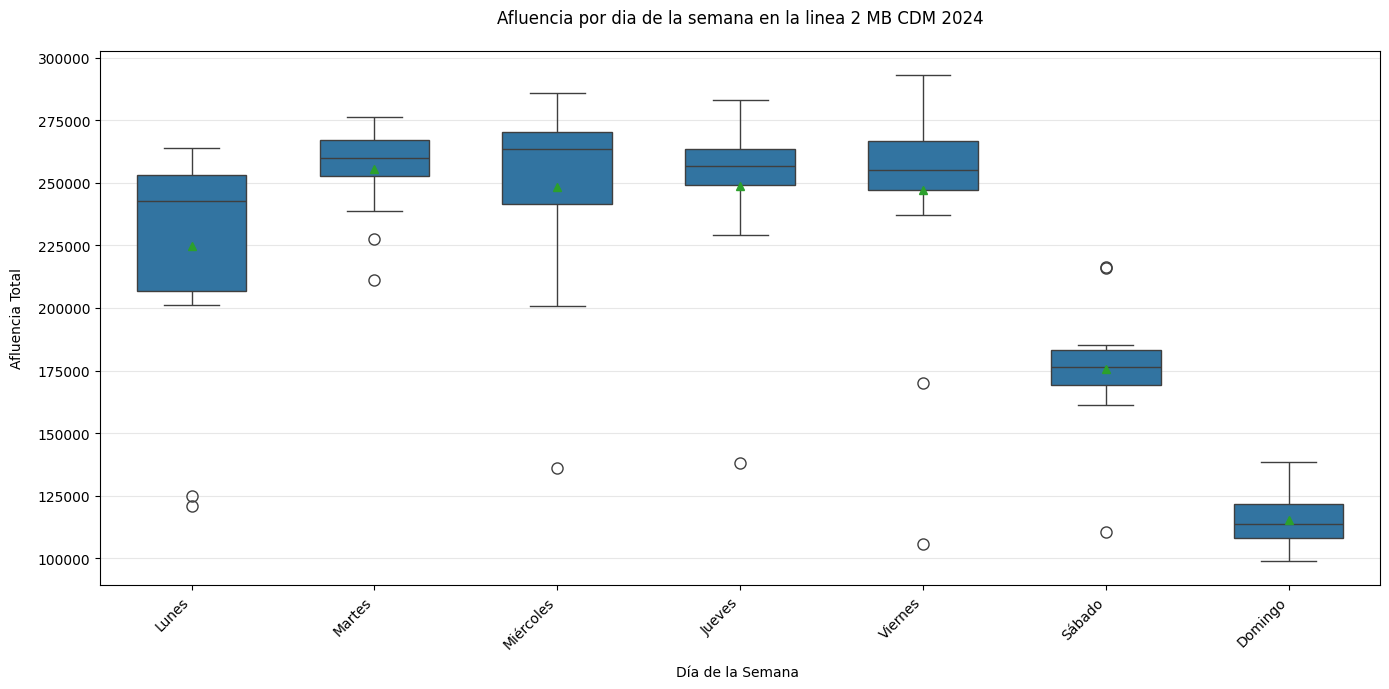

In [389]:
#Diagrama de bigotes para afluencia por dia de la semana para la linea 2
# Tamaño
plt.figure(figsize=(14, 7))

# Gráfico de caja
sns.boxplot(
    x='dia_semana',
    y='afluencia_total',
    data=df_linea2,
    showmeans=True,  # La media se muestra con un triangulo verde
    flierprops={'marker': 'o', 'markersize': 8},  #Outliers se muestran con un circulo
    width=0.6
)

# Etiquetas para el titulo, eje x y eje y
plt.title('Afluencia por dia de la semana en la linea 2 MB CDM 2024', pad=20)
plt.xlabel('Día de la Semana ', labelpad=10)
plt.ylabel('Afluencia Total', labelpad=10)

# Etiquetas eje x para dias de la semana
plt.xticks(ticks=range(7), labels=nombres_dias, rotation=45, ha='right')

# Ajustes de espacio
plt.tight_layout()
plt.grid(axis='y', alpha=0.3)
plt.show()

#ACF Y PACF

In [390]:
#LINEA 1

<Figure size 1200x600 with 0 Axes>

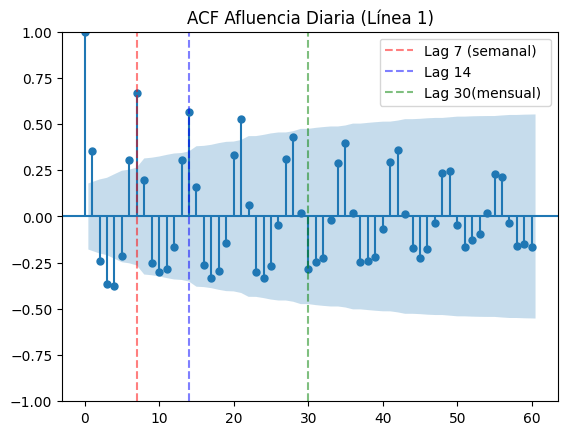

In [391]:
#  ACF
plt.figure(figsize=(12, 6))
plot_acf(df_linea1['afluencia_total'],
         lags=60,          # Analiza los primeros 60 lags (2 meses)
         alpha=0.05,       # Intervalo de confianza del 95%
         title='ACF Afluencia Diaria (Línea 1)')
plt.axvline(x=7, color='red', linestyle='--', alpha=0.5, label='Lag 7 (semanal)')
plt.axvline(x=14, color='blue', linestyle='--', alpha=0.5, label='Lag 14 ')
plt.axvline(x=30, color='green', linestyle='--', alpha=0.5, label='Lag 30(mensual) ')
plt.legend()
plt.show()

<Figure size 1200x600 with 0 Axes>

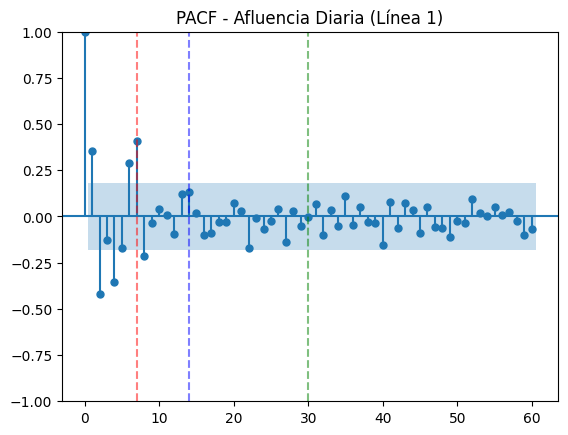

In [392]:
# PACF (Función de Autocorrelación Parcial)
plt.figure(figsize=(12, 6))
plot_pacf(df_linea1['afluencia_total'],
          lags=60,
          alpha=0.05,
          title='PACF - Afluencia Diaria (Línea 1)')
plt.axvline(x=7, color='red', linestyle='--', alpha=0.5)
plt.axvline(x=14, color='blue', linestyle='--', alpha=0.5, label='Lag 14 ')
plt.axvline(x=30, color='green', linestyle='--', alpha=0.5)
plt.show()

Podemos observar que en la linea 1 encontramos patrones semanales, ya que en el PACF encotramos una relacion significativa respecto el valor actual y el de hace una semana (lag 7) por lo tanto se puede interpretar la existencia de patrones estacionales es decir los valores de la semana pasada seran similares a los de esta semana

In [393]:
#LINEA 2

<Figure size 1200x600 with 0 Axes>

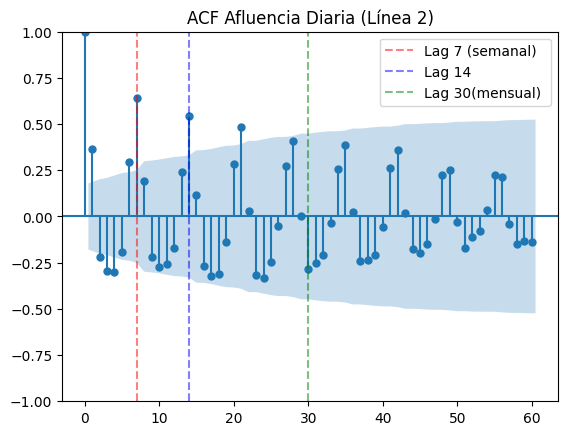

In [394]:
# ACF (Función de Autocorrelación)
plt.figure(figsize=(12, 6))
plot_acf(df_linea2['afluencia_total'],
         lags=60,          # Analisis de los primeros 60 dias
         alpha=0.05,       # Intervalo de confianza del 95%
         title='ACF Afluencia Diaria (Línea 2)')

#Grafico
plt.axvline(x=7, color='red', linestyle='--', alpha=0.5, label='Lag 7 (semanal)')
plt.axvline(x=14, color='blue', linestyle='--', alpha=0.5, label='Lag 14 ')
plt.axvline(x=30, color='green', linestyle='--', alpha=0.5, label='Lag 30(mensual) ')
plt.legend()
plt.show()

<Figure size 1200x600 with 0 Axes>

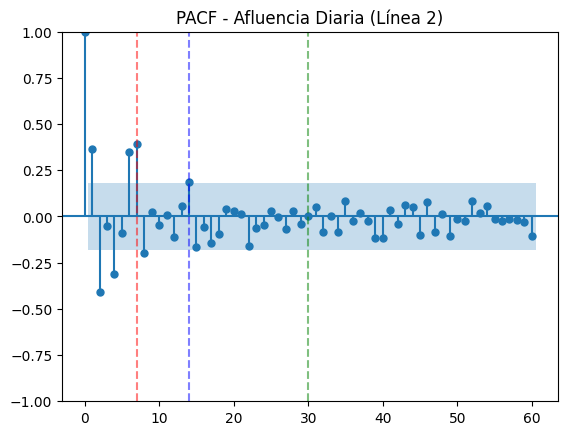

In [395]:
# 2. PACF (Función de Autocorrelación Parcial)
#Tamaño
plt.figure(figsize=(12, 6))
plot_pacf(df_linea2['afluencia_total'],
          lags=60,
          alpha=0.05,
          title='PACF - Afluencia Diaria (Línea 2)')

#Grafico
plt.axvline(x=7, color='red', linestyle='--', alpha=0.5)
plt.axvline(x=14, color='blue', linestyle='--', alpha=0.5, label='Lag 14 ')
plt.axvline(x=30, color='green', linestyle='--', alpha=0.5)
plt.show()

Podemos observar que en la linea 2 se comporta de manera muy similar a la linea 1, en pocas palabras encontramos patrones semanales, ya que en el PACF se ve una relacion significativa respecto el valor actual y el de hace una semana (lag 7) por lo tanto se puede interpretar la existencia de patrones estacionales es decir los valores de la semana pasada seran similares a los de esta semana

#UNION DE LINEAS PARA CONSTRUCCION DEL MODELO

In [396]:
# Se renombra la afluencia_total para evitar confuciones para la linea 1
df_linea1_renombrado = df_linea1.rename(columns={'afluencia_total': 'afluencia_linea1'})

# Se realiza lo mismo pero para la linea 2
afluencia_linea2 = df_linea2[['afluencia_total']].rename(columns={'afluencia_total': 'afluencia_linea2'})

In [397]:
# Union solo de la columna de afluencia de la linea 2
df_combinado = df_linea1_renombrado.join(afluencia_linea2)

#Reordenar las columnas
columnas_ordenadas = [
    'fecha', 'linea', 'mes', 'anio', 'temporal_fecha',
    'afluencia_linea1', 'afluencia_linea2',
    'temp_aire_celsius', 'precipitacion', 'humedad_especifica',
    'humedad_relativa', 'dia_semana', 'dia_mes',
    'tipo_dia_Entre Semana', 'tipo_dia_Feriado', 'tipo_dia_Fin de Semana'
]

# Se reasigna el df ordenado
df_combinado = df_combinado[columnas_ordenadas]

In [398]:
#Df con la afluencia de la linea 1 y 2 para el año del 2024
df_combinado.head()

,fecha,linea,mes,anio,temporal_fecha,afluencia_linea1,afluencia_linea2,temp_aire_celsius,precipitacion,humedad_especifica,humedad_relativa,dia_semana,dia_mes,tipo_dia_Entre Semana,tipo_dia_Feriado,tipo_dia_Fin de Semana
0,2024-02-01,Línea 1,Febrero,2024,2024-02,494567,264127,11.26,0.1,6.75,62.22,3,1,True,False,False
1,2024-02-02,Línea 1,Febrero,2024,2024-02,475543,245044,11.96,0.0,6.87,65.43,4,2,True,False,False
2,2024-02-03,Línea 1,Febrero,2024,2024-02,301361,182256,10.47,0.0,6.42,66.60,5,3,False,False,True
3,2024-02-04,Línea 1,Febrero,2024,2024-02,192326,108203,10.29,0.0,3.41,42.31,6,4,False,False,True
4,2024-02-05,Línea 1,Febrero,2024,2024-02,218310,120915,10.02,0.0,2.89,31.92,0,5,False,True,False


In [399]:
#Columnas del df
print(df_combinado.columns)

Index(['fecha', 'linea', 'mes', 'anio', 'temporal_fecha', 'afluencia_linea1',
       'afluencia_linea2', 'temp_aire_celsius', 'precipitacion',
       'humedad_especifica', 'humedad_relativa', 'dia_semana', 'dia_mes',
       'tipo_dia_Entre Semana', 'tipo_dia_Feriado', 'tipo_dia_Fin de Semana'],
      dtype='object')


#CREACION DE MEDIAS MOVILES POR LINEA

In [400]:
# Copia del df anterior
df_commbinado_con_medias_moviles = df_combinado.copy()

# Medias móviles para Línea 1 (ventana de 7 y 14 movil average)
df_commbinado_con_medias_moviles['ma7_linea1'] = df_commbinado_con_medias_moviles['afluencia_linea1'].shift(1).rolling(7).mean() #(movil average)
df_commbinado_con_medias_moviles['ma14_linea1'] = df_commbinado_con_medias_moviles['afluencia_linea1'].shift(1).rolling(14).mean()

# Medias móviles para Linea 2 (ventana de 7 y 14 movil average)
df_commbinado_con_medias_moviles['ma7_linea2'] = df_commbinado_con_medias_moviles['afluencia_linea2'].shift(1).rolling(7).mean()# (movil average)
df_commbinado_con_medias_moviles['ma14_linea2'] = df_commbinado_con_medias_moviles['afluencia_linea2'].shift(1).rolling(14).mean()


#CONSTRUCCION DE LAGS

In [401]:
#Creacion de los lags
lags_linea1 = [7,8, 14]  # Lags para la linea 1
lags_linea2 = [7,8, 14]        # Lags significativos para Línea 2 (de PACF)

In [402]:
#Funcion para crear los lags
def crear_lags_por_linea(df, lags_linea1, lags_linea2):
    df = df.copy()

    # Lags linea 1
    for lag in lags_linea1:
        df[f'lag{lag}_linea1'] = df['afluencia_linea1'].shift(lag)

    # Lags linea 2
    for lag in lags_linea2:
        df[f'lag{lag}_linea2'] = df['afluencia_linea2'].shift(lag)

    df = df.dropna()

    return df

In [403]:
#Implementacion de el df ya con los lags correspondientes
df_combinado_con_lags = crear_lags_por_linea(df_commbinado_con_medias_moviles, lags_linea1, lags_linea2)

In [404]:
#Muestra los primeros datos ya con los lags y ma (media movil/ movil average)
df_combinado_con_lags.head()

,fecha,linea,mes,anio,temporal_fecha,afluencia_linea1,afluencia_linea2,temp_aire_celsius,precipitacion,humedad_especifica,...,ma7_linea1,ma14_linea1,ma7_linea2,ma14_linea2,lag7_linea1,lag8_linea1,lag14_linea1,lag7_linea2,lag8_linea2,lag14_linea2
14,2024-02-15,Línea 1,Febrero,2024,2024-02,496810,261882,13.40,0.02,7.44,...,428242.285714,404091.000000,226165.571429,215116.000000,495637.0,491789.0,494567.0,252035.0,253020.0,264127.0
15,2024-02-16,Línea 1,Febrero,2024,2024-02,516159,264425,12.06,5.91,7.77,...,428409.857143,404251.214286,227572.285714,214955.642857,510980.0,495637.0,475543.0,267524.0,252035.0,245044.0
16,2024-02-17,Línea 1,Febrero,2024,2024-02,301616,168821,8.63,9.41,6.85,...,429149.714286,407152.357143,227129.571429,216340.000000,309148.0,510980.0,301361.0,169065.0,267524.0,182256.0
17,2024-02-18,Línea 1,Febrero,2024,2024-02,215366,138378,9.79,0.14,4.88,...,428073.714286,407170.571429,227094.714286,215380.357143,201624.0,309148.0,192326.0,118906.0,169065.0,108203.0
18,2024-02-19,Línea 1,Febrero,2024,2024-02,480115,238811,11.92,0.00,3.26,...,430036.857143,408816.285714,229876.428571,217535.714286,477328.0,201624.0,218310.0,242799.0,118906.0,120915.0


In [405]:
#CONVERSION DE MESES A NUMERO
# Diccionario de conversión de meses
meses_a_numero = {
    'Enero': 1, 'Febrero': 2, 'Marzo': 3, 'Abril': 4,
    'Mayo': 5, 'Junio': 6, 'Julio': 7, 'Agosto': 8,
    'Septiembre': 9, 'Octubre': 10, 'Noviembre': 11, 'Diciembre': 12
}

# Aplicar la conversión
df_combinado_con_lags['mes'] = df_combinado_con_lags['mes'].map(meses_a_numero)


In [406]:
#Datos con el mes cambiado a numero
df_combinado_con_lags.head()

,fecha,linea,mes,anio,temporal_fecha,afluencia_linea1,afluencia_linea2,temp_aire_celsius,precipitacion,humedad_especifica,...,ma7_linea1,ma14_linea1,ma7_linea2,ma14_linea2,lag7_linea1,lag8_linea1,lag14_linea1,lag7_linea2,lag8_linea2,lag14_linea2
14,2024-02-15,Línea 1,2,2024,2024-02,496810,261882,13.40,0.02,7.44,...,428242.285714,404091.000000,226165.571429,215116.000000,495637.0,491789.0,494567.0,252035.0,253020.0,264127.0
15,2024-02-16,Línea 1,2,2024,2024-02,516159,264425,12.06,5.91,7.77,...,428409.857143,404251.214286,227572.285714,214955.642857,510980.0,495637.0,475543.0,267524.0,252035.0,245044.0
16,2024-02-17,Línea 1,2,2024,2024-02,301616,168821,8.63,9.41,6.85,...,429149.714286,407152.357143,227129.571429,216340.000000,309148.0,510980.0,301361.0,169065.0,267524.0,182256.0
17,2024-02-18,Línea 1,2,2024,2024-02,215366,138378,9.79,0.14,4.88,...,428073.714286,407170.571429,227094.714286,215380.357143,201624.0,309148.0,192326.0,118906.0,169065.0,108203.0
18,2024-02-19,Línea 1,2,2024,2024-02,480115,238811,11.92,0.00,3.26,...,430036.857143,408816.285714,229876.428571,217535.714286,477328.0,201624.0,218310.0,242799.0,118906.0,120915.0


In [407]:
# Verifica el total de valores nulos por columna
print(df_combinado_con_lags.isnull().sum())

fecha                     0
linea                     0
mes                       0
anio                      0
temporal_fecha            0
afluencia_linea1          0
afluencia_linea2          0
temp_aire_celsius         0
precipitacion             0
humedad_especifica        0
humedad_relativa          0
dia_semana                0
dia_mes                   0
tipo_dia_Entre Semana     0
tipo_dia_Feriado          0
tipo_dia_Fin de Semana    0
ma7_linea1                0
ma14_linea1               0
ma7_linea2                0
ma14_linea2               0
lag7_linea1               0
lag8_linea1               0
lag14_linea1              0
lag7_linea2               0
lag8_linea2               0
lag14_linea2              0
dtype: int64


#DIVISION DE LOS DATOS

In [408]:
#DIVISION DE LOS DATOS
total_datos = len(df_combinado_con_lags)  # 107 totales
train_size = int(0.8 * total_datos)  # 10 datos (80%)
val_size = int(0.1 * total_datos)    # 12 datos (10%)
test_size = total_datos - train_size - val_size  # 10 datos


# División exacta de train/validation/test
df_train = df_combinado_con_lags.iloc[:train_size]
df_val = df_combinado_con_lags.iloc[train_size:train_size+val_size]
df_test = df_combinado_con_lags.iloc[train_size+val_size:]

#Valores de train/val/test
print(f" Train: {train_size} datos ")
print(f" Val: {val_size} datos ")
print(f" Test: {test_size} datos ")

 Train: 84 datos 
 Val: 10 datos 
 Test: 12 datos 


In [409]:
#Fechas del 2024 que se ocuparan para cada seccion
print("\nFechas en Train:", df_train['fecha'].min(), "a", df_train['fecha'].max())
print("Fechas en Val:", df_val['fecha'].min(), "a", df_val['fecha'].max())
print("Fechas en Test:", df_test['fecha'].min(), "a", df_test['fecha'].max())


Fechas en Train: 2024-02-15 00:00:00 a 2024-05-09 00:00:00
Fechas en Val: 2024-05-10 00:00:00 a 2024-05-19 00:00:00
Fechas en Test: 2024-05-20 00:00:00 a 2024-05-31 00:00:00


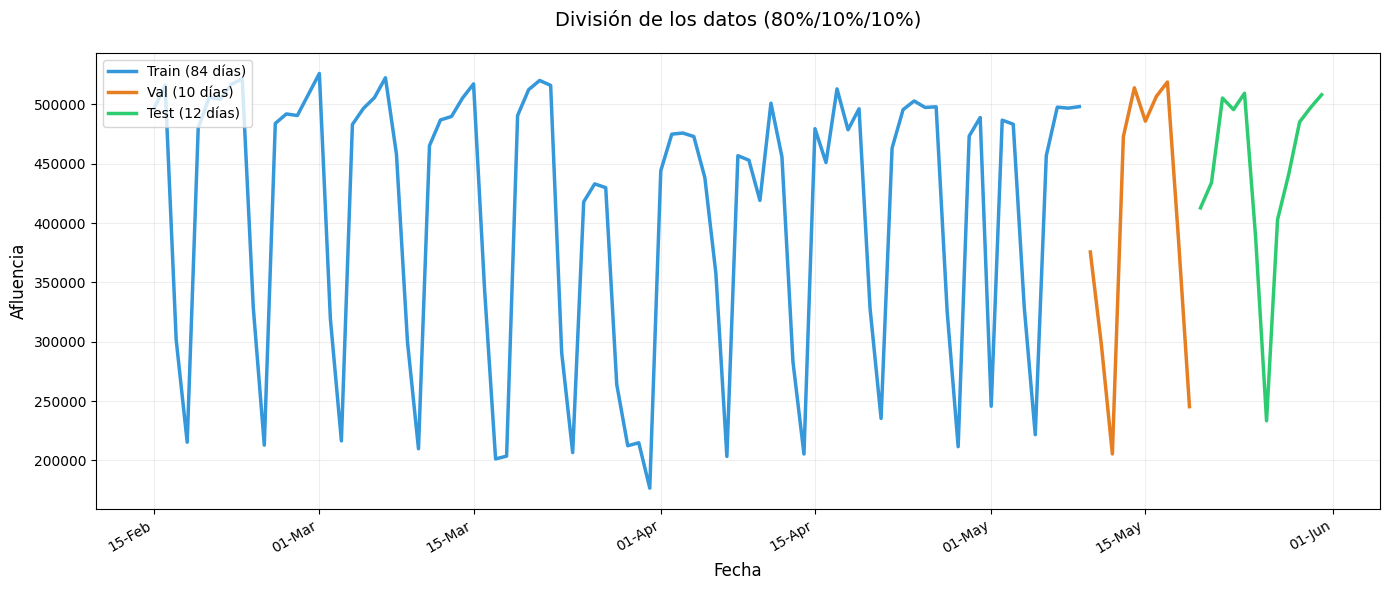

In [410]:
# Configuración del gráfico
plt.figure(figsize=(14, 6))
plt.plot(df_train['fecha'], df_train['afluencia_linea1'],
         '#3498db', label=f'Train ({train_size} días)', linewidth=2.5)
plt.plot(df_val['fecha'], df_val['afluencia_linea1'],
         '#e67e22', label=f'Val ({val_size} días)', linewidth=2.5)
plt.plot(df_test['fecha'], df_test['afluencia_linea1'],
         '#2ecc71', label=f'Test ({test_size} días)', linewidth=2.5)


# Datos del grafico
plt.title('División de los datos (80%/10%/10%)', fontsize=14, pad=20)
plt.xlabel('Fecha', fontsize=12)
plt.ylabel('Afluencia', fontsize=12)
plt.legend(loc='upper left', fontsize=10)
plt.grid(alpha=0.2)

# Formato de fechas
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%d-%b'))
plt.gcf().autofmt_xdate()

plt.tight_layout()
plt.show()

In [411]:
print(df_combinado_con_lags.columns)

Index(['fecha', 'linea', 'mes', 'anio', 'temporal_fecha', 'afluencia_linea1',
       'afluencia_linea2', 'temp_aire_celsius', 'precipitacion',
       'humedad_especifica', 'humedad_relativa', 'dia_semana', 'dia_mes',
       'tipo_dia_Entre Semana', 'tipo_dia_Feriado', 'tipo_dia_Fin de Semana',
       'ma7_linea1', 'ma14_linea1', 'ma7_linea2', 'ma14_linea2', 'lag7_linea1',
       'lag8_linea1', 'lag14_linea1', 'lag7_linea2', 'lag8_linea2',
       'lag14_linea2'],
      dtype='object')


#BUSQUEDA DE HIPERPARAMETROS

In [412]:
# 2. Definir caracteristicas comunes entre ambos df
base_features = [
    'mes', 'anio', 'temp_aire_celsius', 'precipitacion',
    'humedad_especifica', 'humedad_relativa', 'dia_semana', 'dia_mes',
    'tipo_dia_Entre Semana', 'tipo_dia_Feriado', 'tipo_dia_Fin de Semana'
]

# 3. Configuracion de parametros
param_grid = {
    'learning_rate':np.arange(0.005, 0.021, 0.005).tolist(), # Valores de aprendizaje
    'max_depth': [1,2,3],              # Profundidad de los arboles, mayor profundidad capta patrones mas complejos pero puede haber sobreajuste
    'n_estimators': [100, 200],  #Arboles de aprendizaje
    'subsample': [0.7, 0.8],        #Fraccion de muestra usada para entrenar cada arbol
    'colsample_bytree': [0.7, 0.8],  #Características usadas para cada árbol
    'gamma': [0, 0.1, 0.2],              # Pérdida minima para hacer una división en un nodo
    'reg_alpha': [1,2,3,4,5],            # Regularización L1/penaliza pesos grandes
    'reg_lambda': [1,2,3,4,5],           # Regularización L2/reduce magnitud de pesos
    'min_child_weight': [5,7]        # Control de sobreajuste/ restricción que evita que el árbol se divida en nodos con muy pocos datos o con poca "importancia" estadística
}

#BUSQUEDA DE HIPERPARAMETROS LINEA 1

In [413]:

#BUSQUEDA DE HIPERPARAMETROS LINEA 1
# Función de evaluacion para los posibles parametros planteados
def evaluacion_de_hiperparametros_linea1(features, target, X_train, y_train, X_val, y_val):
    model = xgb.XGBRegressor(
        objective='reg:squarederror',
        random_state=42,
        early_stopping_rounds=3,
        n_jobs=-1
    )

    # Validación cruzada temporal (3 pliegues)
    tscv = TimeSeriesSplit(n_splits=3)



    search = RandomizedSearchCV(
        model,
        param_grid,
        cv=tscv,
        scoring='neg_mean_squared_error',
        n_iter=30,
        random_state=42
    )
    eval_size = int(0.2 * len(X_train))
    eval_set = [(X_train[-eval_size:], y_train[-eval_size:])]

    search.fit(
        X_train, y_train,
        eval_set=eval_set,
        verbose=False
    )


  # Evaluación en el conjunto de validacion
    val_pred = search.predict(X_val)
    val_rmse = np.sqrt(mean_squared_error(y_val, val_pred))
    train_rmse = np.sqrt(mean_squared_error(y_train, search.predict(X_train)))
    # Visualizacion del sobreajuste
    overfit = train_rmse - val_rmse

    return {
        'best_params': search.best_params_,
        'train_rmse': train_rmse,
        'val_rmse': val_rmse,
        'overfit': overfit,
        'model': search.best_estimator_
    }

# Evaluación con menos combinaciones
mejores_resultados_linea1 = []
target = 'afluencia_linea1'

# Mejores 2 combinaciones en base al analisis previo
combinaciones_optimizadas_linea1 = [

    ['lag7_linea1', 'lag14_linea1'],
    ["lag7_linea1", "ma7_linea1"],
    ["lag7_linea1", "ma14_linea1"],
    ["lag14_linea1", "ma14_linea1"],
    ['lag7_linea1', 'lag14_linea1', 'ma7_linea1'],
    ['lag7_linea1', 'lag14_linea1', 'ma14_linea1'],
    ['ma7_linea1', 'ma14_linea1'],
    ['lag7_linea1', 'ma7_linea1', 'ma14_linea1']
]

print("EVALUACIÓN PARAMETROS LINEA 1")
for lags in combinaciones_optimizadas_linea1:
    features = base_features + lags

    # Preparar datos
    X_train = df_train[features]
    y_train = df_train[target]
    X_val = df_val[features]
    y_val = df_val[target]

    # Evalua modelo
    resultado = evaluacion_de_hiperparametros_linea1(features, target, X_train, y_train, X_val, y_val)

    print(f"\nCombinación: {lags}")
    print(f"RMSE Entrenamiento: {resultado['train_rmse']:.2f}")
    print(f"RMSE Validación: {resultado['val_rmse']:.2f}")
    print(f"Diferencia (sobreajuste): {resultado['overfit']:.2f}")

    mejores_resultados_linea1.append(resultado)

# Selección del mejor modelo
mejor_modelo_linea1 = min(mejores_resultados_linea1, key=lambda x: x['val_rmse'])

print("\n MEJOR MODELO ")
print(f"Combinación de lags: {combinaciones_optimizadas_linea1[mejores_resultados_linea1.index(mejor_modelo_linea1)]}")
print(f"RMSE Validación: {mejor_modelo_linea1['val_rmse']:.2f}")
print(f"Parametros: {mejor_modelo_linea1['best_params']}")
print(f"Diferencia entrenamiento/validación: {mejor_modelo_linea1['overfit']:.2f}")



EVALUACIÓN PARAMETROS LINEA 1

Combinación: ['lag7_linea1', 'lag14_linea1']
RMSE Entrenamiento: 43573.78
RMSE Validación: 46212.92
Diferencia (sobreajuste): -2639.15

Combinación: ['lag7_linea1', 'ma7_linea1']
RMSE Entrenamiento: 39579.02
RMSE Validación: 48518.64
Diferencia (sobreajuste): -8939.62

Combinación: ['lag7_linea1', 'ma14_linea1']
RMSE Entrenamiento: 33646.37
RMSE Validación: 51814.56
Diferencia (sobreajuste): -18168.20

Combinación: ['lag14_linea1', 'ma14_linea1']
RMSE Entrenamiento: 37870.78
RMSE Validación: 51697.07
Diferencia (sobreajuste): -13826.29

Combinación: ['lag7_linea1', 'lag14_linea1', 'ma7_linea1']
RMSE Entrenamiento: 41135.53
RMSE Validación: 49463.00
Diferencia (sobreajuste): -8327.47

Combinación: ['lag7_linea1', 'lag14_linea1', 'ma14_linea1']
RMSE Entrenamiento: 39518.17
RMSE Validación: 52777.54
Diferencia (sobreajuste): -13259.37

Combinación: ['ma7_linea1', 'ma14_linea1']
RMSE Entrenamiento: 53045.86
RMSE Validación: 51613.08
Diferencia (sobreajuste): 

#BUSQUEDA DE HIPERPARAMETROS LINEA 2

In [414]:
#Función de evaluacion linea 2
def evaluacion_de_hiperparametros_linea2(features, target, X_train, y_train, X_val, y_val):
    model = xgb.XGBRegressor(
        objective='reg:squarederror',
        random_state=42,
        early_stopping_rounds=3,
        n_jobs=-1
    )

    tscv = TimeSeriesSplit(n_splits=3)

    search = RandomizedSearchCV(
        model,
        param_grid,
        cv=tscv,
        scoring='neg_mean_squared_error',
        n_iter=30,
        random_state=42
    )

    eval_size = int(0.2 * len(X_train))
    eval_set = [(X_train[-eval_size:], y_train[-eval_size:])]

    search.fit(
        X_train, y_train,
        eval_set=eval_set,
        verbose=False
    )

    val_pred = search.predict(X_val)
    val_rmse = np.sqrt(mean_squared_error(y_val, val_pred))
    train_rmse = np.sqrt(mean_squared_error(y_train, search.predict(X_train)))
    overfit = train_rmse - val_rmse

    return {
        'best_params': search.best_params_,
        'train_rmse': train_rmse,
        'val_rmse': val_rmse,
        'overfit': overfit,
        'model': search.best_estimator_
    }

# Evaluación para Línea 2
mejores_resultados_linea2 = []
target = 'afluencia_linea2'

# Mismas combinaciones que para Línea 1
combinaciones_optimizadas_linea2 = [
    ['lag7_linea2', 'lag14_linea2'],
    ["lag7_linea2", "ma7_linea2"],
    ["lag7_linea2", "ma14_linea2"],
    ["lag14_linea2", "ma14_linea2"],
    ['lag7_linea2', 'lag14_linea2', 'ma7_linea2'],
    ['lag7_linea2', 'lag14_linea2', 'ma14_linea2'],
    ['ma7_linea2', 'ma14_linea2'],
    ['lag7_linea2', 'ma7_linea2', 'ma14_linea2']
]

print("EVALUACIÓN PARAMETROS LINEA 2")
for lags in combinaciones_optimizadas_linea2:
    features = base_features + lags

    X_train = df_train[features]
    y_train = df_train[target]
    X_val = df_val[features]
    y_val = df_val[target]

    resultado = evaluacion_de_hiperparametros_linea2(features, target, X_train, y_train, X_val, y_val)

    print(f"\nCombinación: {lags}")
    print(f"RMSE Entrenamiento: {resultado['train_rmse']:.2f}")
    print(f"RMSE Validación: {resultado['val_rmse']:.2f}")
    print(f"Diferencia (sobreajuste): {resultado['overfit']:.2f}")

    mejores_resultados_linea2.append(resultado)

# Selección del mejor modelo para Línea 2
mejor_modelo_linea2 = min(mejores_resultados_linea2, key=lambda x: x['val_rmse'])

print("\n MEJOR MODELO LINEA 2")
print(f"Combinación de lags: {combinaciones_optimizadas_linea2[mejores_resultados_linea2.index(mejor_modelo_linea2)]}")
print(f"RMSE Validación: {mejor_modelo_linea2['val_rmse']:.2f}")
print(f"Parametros: {mejor_modelo_linea2['best_params']}")
print(f"Diferencia entrenamiento/validación: {mejor_modelo_linea2['overfit']:.2f}")

EVALUACIÓN PARAMETROS LINEA 2

Combinación: ['lag7_linea2', 'lag14_linea2']
RMSE Entrenamiento: 30010.78
RMSE Validación: 35402.74
Diferencia (sobreajuste): -5391.96

Combinación: ['lag7_linea2', 'ma7_linea2']
RMSE Entrenamiento: 17661.35
RMSE Validación: 36841.93
Diferencia (sobreajuste): -19180.58

Combinación: ['lag7_linea2', 'ma14_linea2']
RMSE Entrenamiento: 17881.12
RMSE Validación: 35793.09
Diferencia (sobreajuste): -17911.97

Combinación: ['lag14_linea2', 'ma14_linea2']
RMSE Entrenamiento: 18937.06
RMSE Validación: 34108.70
Diferencia (sobreajuste): -15171.63

Combinación: ['lag7_linea2', 'lag14_linea2', 'ma7_linea2']
RMSE Entrenamiento: 20107.26
RMSE Validación: 37079.19
Diferencia (sobreajuste): -16971.92

Combinación: ['lag7_linea2', 'lag14_linea2', 'ma14_linea2']
RMSE Entrenamiento: 21104.22
RMSE Validación: 35200.24
Diferencia (sobreajuste): -14096.03

Combinación: ['ma7_linea2', 'ma14_linea2']
RMSE Entrenamiento: 17361.11
RMSE Validación: 35850.07
Diferencia (sobreajuste)

#IMPLEMENTACION DEL MODELO LINEA 1 (2024)

In [415]:
#HIPERPARAMETROS RECOMENDADOS PARA LA LINEA 1
print("Hiperparametros recomendados para la linea 1:", mejor_modelo_linea1['best_params'])
print("Lags recomendados para la linea 1:", combinaciones_optimizadas_linea1[mejores_resultados_linea1.index(mejor_modelo_linea1)])

Hiperparametros recomendados para la linea 1: {'subsample': 0.8, 'reg_lambda': 3, 'reg_alpha': 2, 'n_estimators': 200, 'min_child_weight': 5, 'max_depth': 2, 'learning_rate': 0.015, 'gamma': 0.2, 'colsample_bytree': 0.7}
Lags recomendados para la linea 1: ['lag7_linea1', 'lag14_linea1']


En la busqueda de hiperparametros para la linea 1 y al probar los lags y MA se encontro que la que tenia el RMSE mas bajo en validacion era ['lag4_linea1', 'lag 14_linea1'] con un valor de 48,246.13, sin embargo para el modelo final se implemento ['lag7_linea1', 'lag14_linea1', 'ma7_linea1'] con un RMSE en validacion de 50,340.94 debido a que la diferencia entre ambas es pequeña y podria existir una mejor captura de patrones semanales

In [416]:
# Linea 1 caracteristicas finales para implementacion
#Features finales para la linea 1
features_finales_linea1 = base_features + ['lag7_linea1', 'lag14_linea1', 'ma7_linea1']
#Union del train y val
X_train_val = pd.concat([df_train, df_val])[features_finales_linea1]
y_train_val = pd.concat([df_train, df_val])['afluencia_linea1']
#Evalucacion de los datos en test
X_test = df_test[features_finales_linea1]
y_test = df_test['afluencia_linea1']

In [417]:
#Configuracion de XGBOOST
modelo_final_linea1 = xgb.XGBRegressor(
    objective='reg:squarederror',
    **mejor_modelo_linea1['best_params'],  #Mejores parametros encontrados
    n_jobs=-1,
    random_state=42
)

#  Entrenamiento
modelo_final_linea1.fit(X_train_val, y_train_val)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.7, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=0.2, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.015, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=2, max_leaves=None,
             min_child_weight=5, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=200, n_jobs=-1,
             num_parallel_tree=None, random_state=42, ...)

#METRICAS LINEA 1 2024

In [418]:
# Predicciones para la linea 1
test_pred = modelo_final_linea1.predict(X_test)

# Métricas
#RMSE
rmse_test = np.sqrt(mean_squared_error(y_test, test_pred))
#MAE
mae_test = mean_absolute_error(y_test, test_pred)
# MAPE
mape_test = np.mean(np.abs((y_test - test_pred) / y_test)) * 100

#Impresion de las metricas
print(f"Metricas para la linea 1 (2024):")
print(f"RMSE en test: {rmse_test:.2f}")
print(f"MAE en test: {mae_test:.2f}")
print(f"MAPE en test: {mape_test:.2f}%")


Metricas para la linea 1 (2024):
RMSE en test: 49624.62
MAE en test: 43839.39
MAPE en test: 10.09%


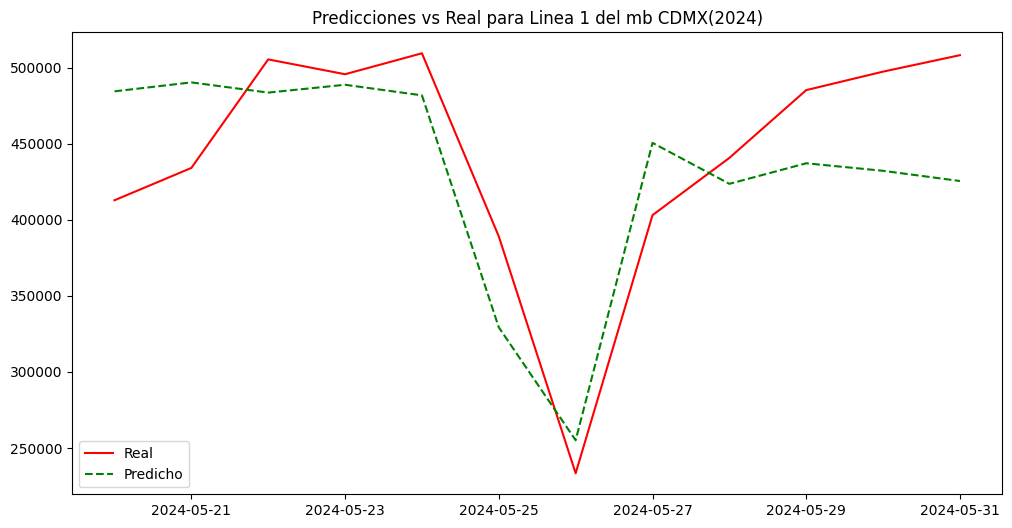

In [419]:
# Gráfico de predicciones vs real
plt.figure(figsize=(12, 6))
plt.plot(df_test['fecha'], y_test, label='Real', color='red')
plt.plot(df_test['fecha'], test_pred, label='Predicho', linestyle='--', color='green')
plt.title('Predicciones vs Real para Linea 1 del mb CDMX(2024)')
plt.legend()
plt.show()

#IMPLEMENTACION DEL MODELO PARA LA LINEA 2

In [420]:
#HIPERPARAMETROS RECOMENDADOS PARA LA LINEA 2
print("Hiperparametros recomendados para la linea 2:", mejor_modelo_linea2['best_params'])
print("Lags y MA recomendafos para la linea 2:", combinaciones_optimizadas_linea2[mejores_resultados_linea2.index(mejor_modelo_linea2)])

Hiperparametros recomendados para la linea 2: {'subsample': 0.7, 'reg_lambda': 3, 'reg_alpha': 4, 'n_estimators': 200, 'min_child_weight': 5, 'max_depth': 3, 'learning_rate': 0.015, 'gamma': 0.1, 'colsample_bytree': 0.8}
Lags y MA recomendafos para la linea 2: ['lag14_linea2', 'ma14_linea2']


En la busqueda de hiperparametros para la linea 2 y al probar los lags y MA se encontro que la que tenia el RMSE mas bajo en validacion era ['lag14_linea2', 'ma14_linea2'] con un valor de 32665.97 ,  sin embargo he decidido implementar para el modelo final  ['lag7_linea2', 'lag14_linea2', 'ma14_linea2'] con un
RMSE en validacion de 33645.65 debido a que la diferencia entre ambas es alrededor de un 3% y podria existir una mejor captura de patrones semanales

In [421]:
# Features finales
features_finales_linea2 = base_features + ['lag7_linea2','lag14_linea2','ma14_linea2' ]  # << Reemplaza con la mejor combinación encontrada para Línea 2

# 2. Unir train + validation para Línea 2
X_train_val_linea2 = pd.concat([df_train, df_val])[features_finales_linea2]
y_train_val_linea2 = pd.concat([df_train, df_val])['afluencia_linea2']  # << Target de Línea 2

# 3. Preparar datos de test para Línea 2
X_test_linea2 = df_test[features_finales_linea2]
y_test_linea2 = df_test['afluencia_linea2']



In [422]:
# 4. Configurar modelo para klínea 2
modelo_final_linea2 = xgb.XGBRegressor(
    objective='reg:squarederror',
    **mejor_modelo_linea2['best_params'],  # << Hiperparámetros óptimos de Línea 2
    n_jobs=-1,
    random_state=42
)

# Entrenar el modelo para línea 2
modelo_final_linea2.fit(X_train_val_linea2, y_train_val_linea2)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=0.1, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.015, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=5, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=200, n_jobs=-1,
             num_parallel_tree=None, random_state=42, ...)

#METRICAS PARA LA LINEA 2 (2024)

In [423]:
#Evaluar en test para línea 2 para 2024
y_pred_linea2 = modelo_final_linea2.predict(X_test_linea2)
rmse_test_linea2 = np.sqrt(mean_squared_error(y_test_linea2, y_pred_linea2))
mae_test_linea2 = mean_absolute_error(y_test_linea2, y_pred_linea2)
mape_test_linea2 = np.mean(np.abs((y_test_linea2 - y_pred_linea2) / y_test_linea2)) * 100

print(f"\Metricas para Linea 2 (2024):")
print(f"- RMSE en test: {rmse_test_linea2:.2f}")
print(f"- MAE en test: {mae_test_linea2:.2f}")
print(f"- MAPE en test: {mape_test_linea2:.2f}%")

\Metricas para Linea 2 (2024):
- RMSE en test: 23082.20
- MAE en test: 19122.95
- MAPE en test: 9.62%


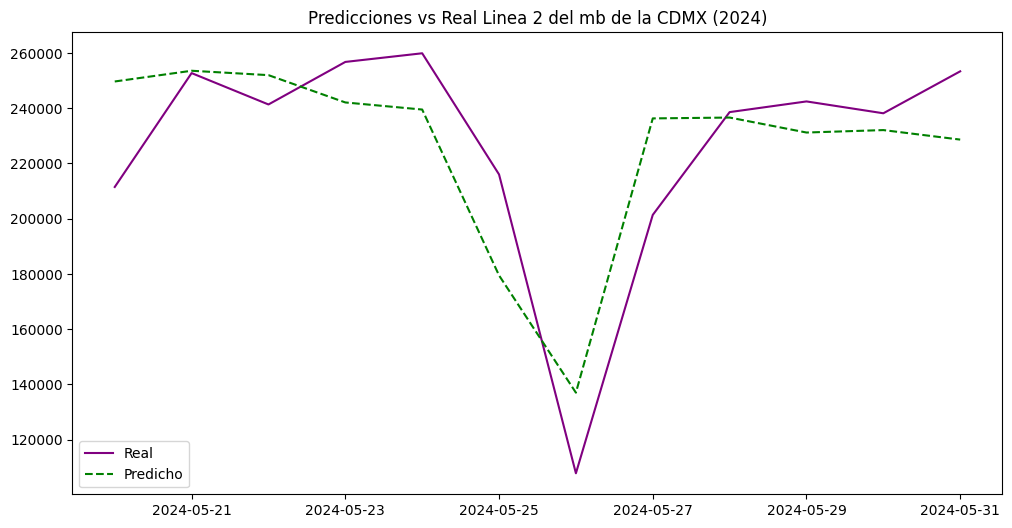

In [424]:
#Grafico para Linea 2
plt.figure(figsize=(12, 6))
plt.plot(df_test['fecha'], y_test_linea2, label='Real', color='purple')
plt.plot(df_test['fecha'], y_pred_linea2, label='Predicho', linestyle='--', color='green')
plt.title('Predicciones vs Real Linea 2 del mb de la CDMX (2024)')
plt.legend()
plt.show()

In [425]:
print(modelo_final_linea1.feature_names_in_)


['mes' 'anio' 'temp_aire_celsius' 'precipitacion' 'humedad_especifica'
 'humedad_relativa' 'dia_semana' 'dia_mes' 'tipo_dia_Entre Semana'
 'tipo_dia_Feriado' 'tipo_dia_Fin de Semana' 'lag7_linea1' 'lag14_linea1'
 'ma7_linea1']


In [426]:
print(modelo_final_linea2.feature_names_in_)

['mes' 'anio' 'temp_aire_celsius' 'precipitacion' 'humedad_especifica'
 'humedad_relativa' 'dia_semana' 'dia_mes' 'tipo_dia_Entre Semana'
 'tipo_dia_Feriado' 'tipo_dia_Fin de Semana' 'lag7_linea2' 'lag14_linea2'
 'ma14_linea2']


#PREDICCIONES PARA 2025


In [427]:
#Base de datos para las predicciones de 2025

# Fechas para 2025 (febrero a mayo 2025)
fechas_2025 = pd.date_range(start="2025-02-01", end="2025-05-31", freq='D')

# Df base para 2025
df_2025 = pd.DataFrame({'fecha': fechas_2025})

#Implementacion de la funcion
df_2025 = dias_xgboost(df_2025, year=2025).reset_index(drop=True)

# Extraer mes y año
df_2025['mes'] = df_2025['fecha'].dt.month #ya en formato entero
df_2025['anio'] = df_2025['fecha'].dt.year #en formato entero

In [428]:
df_2025.head()

,fecha,dia_semana,dia_mes,tipo_dia_Entre Semana,tipo_dia_Feriado,tipo_dia_Fin de Semana,mes,anio
0,2025-02-01,5,1,False,False,True,2,2025
1,2025-02-02,6,2,False,False,True,2,2025
2,2025-02-03,0,3,False,True,False,2,2025
3,2025-02-04,1,4,True,False,False,2,2025
4,2025-02-05,2,5,True,False,False,2,2025


In [429]:
#Informacion del df hasta el momento
df_2025.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 120 entries, 0 to 119
Data columns (total 8 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   fecha                   120 non-null    datetime64[ns]
 1   dia_semana              120 non-null    int32         
 2   dia_mes                 120 non-null    int32         
 3   tipo_dia_Entre Semana   120 non-null    bool          
 4   tipo_dia_Feriado        120 non-null    bool          
 5   tipo_dia_Fin de Semana  120 non-null    bool          
 6   mes                     120 non-null    int32         
 7   anio                    120 non-null    int32         
dtypes: bool(3), datetime64[ns](1), int32(4)
memory usage: 3.3 KB


In [430]:
#IMPLEMETACION DE DATOS CLIMATOLOGICOS PARA 2025

Los datos del clima fueron obtenidos de
https://power.larc.nasa.gov/data-access-viewer/

In [431]:
# Se agrega las variable de clima (incluye temperatura del aire, precipitacion,humedad especifica y humedad relativa)
#datosclima_2025=pd.read_csv("/content/drive/My Drive/Ciencia de datos/Proyecto final/climacdmx/datosclima2025/clima_2025final.csv")

datosclima_2025 = pd.read_csv("clima_2025final.csv")

In [432]:
#UNION DE LOS DF
#Resetea el indice de cada set
df_2025 = df_2025.reset_index(drop=True)
datosclima_2025 = datosclima_2025.reset_index(drop=True)

# Une solo las columnas de clima por el índice
df_2025 = df_2025.join(datosclima_2025[['temp_aire_celsius', 'precipitacion', 'humedad_especifica', 'humedad_relativa']])



In [433]:
import pandas as pd

# 1. Columnas a convertir
columnas_problematicas = ['temp_aire_celsius', 'precipitacion', 'humedad_especifica', 'humedad_relativa']

# 2. Función para limpieza robusta (con reemplazo de NaN por 0)
def clean_to_float(serie):
    return (
        serie
        .astype(str)
        .str.replace(',', '.', regex=False)  # Reemplazar comas por puntos
        .str.replace(r'[^\d.-]', '', regex=True)  # Eliminar símbolos no numéricos
        .replace('', '0')  # Convertir vacíos a "0" (en lugar de NaN)
        .astype(float)  # Conversión final
    )

# 3. Aplicar a cada columna
for col in columnas_problematicas:
    df_2025[col] = clean_to_float(df_2025[col])


In [434]:
df_2025.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 120 entries, 0 to 119
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   fecha                   120 non-null    datetime64[ns]
 1   dia_semana              120 non-null    int32         
 2   dia_mes                 120 non-null    int32         
 3   tipo_dia_Entre Semana   120 non-null    bool          
 4   tipo_dia_Feriado        120 non-null    bool          
 5   tipo_dia_Fin de Semana  120 non-null    bool          
 6   mes                     120 non-null    int32         
 7   anio                    120 non-null    int32         
 8   temp_aire_celsius       120 non-null    float64       
 9   precipitacion           120 non-null    float64       
 10  humedad_especifica      120 non-null    float64       
 11  humedad_relativa        120 non-null    float64       
dtypes: bool(3), datetime64[ns](1), float64(4), int32(4

#BASE AFLUENCIA 2025(datos de enero 2025 18-31)
Para la generacion de los lags

In [435]:
#Datos de la afluencia de la linea 1, desde el 18 de enero 2025 al 31 de enero 2025 para la generacion de los lags
#datos_afluencia_linea1_2025 = pd.read_csv("/content/drive/My Drive/Ciencia de datos/Proyecto final/afluencia2025/afluencia2025linea1/afluencia_linea1_2025.csv")
datos_afluencia_linea1_2025 = pd.read_csv("afluencia_linea1_2025.csv")
print(datos_afluencia_linea1_2025.head())


        fecha    mes  anio    linea  tipo_pago  afluencia temporal_fecha  \
0  2025-01-18  Enero  2025  Línea 1    Prepago     305807        2025-01   
1  2025-01-18  Enero  2025  Línea 1  Gratuidad      22423        2025-01   
2  2025-01-19  Enero  2025  Línea 1    Prepago     249492        2025-01   
3  2025-01-19  Enero  2025  Línea 1  Gratuidad      15485        2025-01   
4  2025-01-20  Enero  2025  Línea 1    Prepago     392817        2025-01   

   ..anio_fecha  
0          2025  
1          2025  
2          2025  
3          2025  
4          2025  


In [436]:
#Se aplica la funcion procesar_afluencia para unir los datos
#Linea 1
datos_afluencia_linea1_2025_procesado = procesar_afluencia(datos_afluencia_linea1_2025)
#Se renombra la columna de afluencia total para mayor claridad
datos_afluencia_linea1_2025_procesado.rename(columns={'afluencia_total': 'afluenciat_linea1_2025'}, inplace=True)
print(datos_afluencia_linea1_2025_procesado.head())
print(datos_afluencia_linea1_2025_procesado.info())


        fecha    linea    mes  anio temporal_fecha  ..anio_fecha  \
0  2025-01-18  Línea 1  Enero  2025        2025-01          2025   
1  2025-01-19  Línea 1  Enero  2025        2025-01          2025   
2  2025-01-20  Línea 1  Enero  2025        2025-01          2025   
3  2025-01-21  Línea 1  Enero  2025        2025-01          2025   
4  2025-01-22  Línea 1  Enero  2025        2025-01          2025   

   afluenciat_linea1_2025  
0                  328230  
1                  264977  
2                  426254  
3                  495448  
4                  509940  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14 entries, 0 to 13
Data columns (total 7 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   fecha                   14 non-null     object
 1   linea                   14 non-null     object
 2   mes                     14 non-null     object
 3   anio                    14 non-null     int64 
 4   temp

#Creacion de lags para la linea 1

In [437]:

# Datos historicos
df_historico_linea1_2025 = datos_afluencia_linea1_2025_procesado.copy()
df_historico_linea1_2025['fecha'] = pd.to_datetime(df_historico_linea1_2025['fecha'])

# Df de prediccion (febrero-mayo 2025)
rango_pred_linea1 = pd.date_range(start="2025-02-01", end="2025-05-31", freq='D')
df_pred_linea1 = pd.DataFrame({
    'fecha': rango_pred_linea1,
    'afluencia': np.nan  # Columna para predicciones futuras
})

#Combinacion de los datos
df_full_linea1_2025 = pd.concat([df_historico_linea1_2025, df_pred_linea1]).sort_values('fecha').reset_index(drop=True)

#Inicializacion de lags
df_full_linea1_2025['lag7_linea1'] = df_full_linea1_2025['afluenciat_linea1_2025'].shift(7)
df_full_linea1_2025['lag14_linea1'] = df_full_linea1_2025['afluenciat_linea1_2025'].shift(14)
df_full_linea1_2025['ma7_linea1'] = np.nan  # Inicializar como NaN

# Simulacion de los lags y ma
for i in range(len(df_full_linea1_2025)):
    if pd.isna(df_full_linea1_2025.loc[i, 'afluenciat_linea1_2025']):

        if i < 1:  # Para el primer día de predicción
            valor_base = df_full_linea1_2025.loc[i-1, 'afluenciat_linea1_2025'] if i > 0 else df_historico_linea1_2025['afluenciat_linea1_2025'].iloc[-1]
        else:
            valor_base = df_full_linea1_2025.loc[i-1, 'afluenciat_linea1_2025']


        df_full_linea1_2025.loc[i, 'afluenciat_linea1_2025'] = valor_base * 0.98  # -2% diario

        # Actualiza los lags
        for dias in [7, 14]:
            if i + dias < len(df_full_linea1_2025):
                df_full_linea1_2025.loc[i+dias, f'lag{dias}_linea1'] = df_full_linea1_2025.loc[i, 'afluenciat_linea1_2025']

        # Actualiza ma
        if i >= 6:
            df_full_linea1_2025.loc[i, 'ma7_linea1'] = df_full_linea1_2025.loc[i-6:i, 'afluenciat_linea1_2025'].mean()
        # Actualizar medias móviles futuras
        for dias_futuros in range(1, min(7, len(df_full_linea1_2025)-i)):
            ventana_inicio = i - 6 + dias_futuros
            if ventana_inicio >= 0:
                df_full_linea1_2025.loc[i+dias_futuros, 'ma7_linea1'] = df_full_linea1_2025.loc[ventana_inicio:i+dias_futuros, 'afluenciat_linea1_2025'].mean()

# Resultados (febrero-mayo 2025)
lags_ma_2025 = df_full_linea1_2025[(df_full_linea1_2025['fecha'] >= '2025-02-01') &
                    (df_full_linea1_2025['fecha'] <= '2025-05-31')].copy()

# Verificación final
print("Valores nulos en lags:", lags_ma_2025[['lag7_linea1', 'lag14_linea1']].isna().sum())
print("\nPrimeras 10 filas:")

Valores nulos en lags: lag7_linea1     0
lag14_linea1    0
dtype: int64

Primeras 10 filas:


In [438]:
#Reseteo del indice para que sea igual al de df_2025
lags_ma_2025.reset_index(drop=True, inplace=True)
print(lags_ma_2025.tail())

         fecha linea  mes  anio temporal_fecha  ..anio_fecha  \
115 2025-05-27   NaN  NaN   NaN            NaN           NaN   
116 2025-05-28   NaN  NaN   NaN            NaN           NaN   
117 2025-05-29   NaN  NaN   NaN            NaN           NaN   
118 2025-05-30   NaN  NaN   NaN            NaN           NaN   
119 2025-05-31   NaN  NaN   NaN            NaN           NaN   

     afluenciat_linea1_2025  afluencia   lag7_linea1  lag14_linea1  \
115            50650.614054        NaN  58344.803964  67207.796258   
116            49637.601773        NaN  57177.907885  65863.640332   
117            48644.849737        NaN  56034.349727  64546.367526   
118            47671.952743        NaN  54913.662733  63255.440175   
119            46718.513688        NaN  53815.389478  61990.331372   

       ma7_linea1  
115  53859.329374  
116  52782.142787  
117  51726.499931  
118  50691.969933  
119  49678.130534  


In [439]:
#DF solo con los lags para la linea 1 del año 2025
df_lags_linea1_2025=lags_ma_2025[['lag7_linea1','lag14_linea1','ma7_linea1']]
print(df_lags_linea1_2025.tail())

      lag7_linea1  lag14_linea1    ma7_linea1
115  58344.803964  67207.796258  53859.329374
116  57177.907885  65863.640332  52782.142787
117  56034.349727  64546.367526  51726.499931
118  54913.662733  63255.440175  50691.969933
119  53815.389478  61990.331372  49678.130534


In [440]:
#Se unen los df
df_completo_linea1_2025 = pd.concat([df_2025.drop(columns=['fecha']), df_lags_linea1_2025], axis=1)
#Orden para que sea el mismo que xgboost
df_completo_linea1_2025 = df_completo_linea1_2025.loc[:, ['mes', 'anio', 'temp_aire_celsius', 'precipitacion', 'humedad_especifica',
               'humedad_relativa', 'dia_semana', 'dia_mes', 'tipo_dia_Entre Semana',
               'tipo_dia_Feriado', 'tipo_dia_Fin de Semana', 'lag7_linea1', 'lag14_linea1',
               'ma7_linea1']]

print(df_completo_linea1_2025.tail())


     mes  anio  temp_aire_celsius  precipitacion  humedad_especifica  \
115    5  2025               19.8           0.20                 7.5   
116    5  2025               19.6           0.10                 7.3   
117    5  2025               19.4           0.05                 7.1   
118    5  2025               19.2           0.00                 6.9   
119    5  2025               19.0           0.00                 6.7   

     humedad_relativa  dia_semana  dia_mes  tipo_dia_Entre Semana  \
115              47.1           1       27                   True   
116              45.8           2       28                   True   
117              44.5           3       29                   True   
118              43.2           4       30                   True   
119              41.9           5       31                  False   

     tipo_dia_Feriado  tipo_dia_Fin de Semana   lag7_linea1  lag14_linea1  \
115             False                   False  58344.803964  67207.796258  

#Prediccion de afluencia para la linea 1

In [441]:
print(modelo_final_linea1.feature_names_in_)
print(df_completo_linea1_2025.columns)

['mes' 'anio' 'temp_aire_celsius' 'precipitacion' 'humedad_especifica'
 'humedad_relativa' 'dia_semana' 'dia_mes' 'tipo_dia_Entre Semana'
 'tipo_dia_Feriado' 'tipo_dia_Fin de Semana' 'lag7_linea1' 'lag14_linea1'
 'ma7_linea1']
Index(['mes', 'anio', 'temp_aire_celsius', 'precipitacion',
       'humedad_especifica', 'humedad_relativa', 'dia_semana', 'dia_mes',
       'tipo_dia_Entre Semana', 'tipo_dia_Feriado', 'tipo_dia_Fin de Semana',
       'lag7_linea1', 'lag14_linea1', 'ma7_linea1'],
      dtype='object')


In [442]:
# Generar predicciones
predicciones_linea1_2025 = modelo_final_linea1.predict(df_completo_linea1_2025)

# Añadir predicciones al DataFrame (opcional)
df_completo_linea1_2025['prediccion'] = predicciones_linea1_2025


In [443]:
print(df_completo_linea1_2025[['prediccion']].tail(50))  # Ultimas filas

        prediccion
70   280299.437500
71   229702.609375
72   447417.750000
73   453648.937500
74   455442.656250
75   455190.281250
76   457288.500000
77   299717.093750
78   248939.453125
79   455551.000000
80   458994.156250
81   456550.250000
82   457933.750000
83   456032.000000
84   294024.156250
85   232150.765625
86   404448.968750
87   410885.593750
88   409254.562500
89   351078.750000
90   458288.062500
91   304779.718750
92   244548.171875
93   452766.406250
94   456189.843750
95   457573.343750
96   457813.125000
97   458288.062500
98   306663.718750
99   255462.343750
100  452496.687500
101  455129.437500
102  455190.281250
103  457933.750000
104  458648.468750
105  306036.718750
106  255259.171875
107  456361.406250
108  458994.156250
109  456550.250000
110  456550.250000
111  455144.156250
112  303875.000000
113  253521.218750
114  451282.531250
115  431063.093750
116  410885.593750
117  410885.593750
118  408096.000000
119  285827.562500


In [444]:
#Predicciones para la afluencia linea 2 2025 (febrero a mayo 2025)
df_predicciones_final_linea1_2025= pd.DataFrame({
    'fecha': fechas_2025,
    'prediccion_afluencia_linea1_2025': predicciones_linea1_2025
})


# 4. Mostrar las primeras filas
print("Primeras 5 predicciones para la afluencia :")
print(df_predicciones_final_linea1_2025.tail())

Primeras 5 predicciones para la afluencia :
         fecha  prediccion_afluencia_linea1_2025
115 2025-05-27                      431063.09375
116 2025-05-28                      410885.59375
117 2025-05-29                      410885.59375
118 2025-05-30                      408096.00000
119 2025-05-31                      285827.56250


In [445]:
# Diccionario de meses en español
meses_es = {
    1: 'Enero', 2: 'Febrero', 3: 'Marzo', 4: 'Abril',
    5: 'Mayo', 6: 'Junio', 7: 'Julio', 8: 'Agosto',
    9: 'Septiembre', 10: 'Octubre', 11: 'Noviembre', 12: 'Diciembre'
}

# Columanas en español
df_predicciones_final_linea1_2025['mes'] = (
    df_predicciones_final_linea1_2025['fecha'].dt.month.map(meses_es))

print(df_predicciones_final_linea1_2025.tail())

         fecha  prediccion_afluencia_linea1_2025   mes
115 2025-05-27                      431063.09375  Mayo
116 2025-05-28                      410885.59375  Mayo
117 2025-05-29                      410885.59375  Mayo
118 2025-05-30                      408096.00000  Mayo
119 2025-05-31                      285827.56250  Mayo


#Datos de afluencia de la linea  2 del 18 al 31 de enero 2025

In [446]:
#Datos de la afluencia de la linea 2, desde el 18 de enero 2025 al 31 de enero 2025 para la generacion de los lags
#datos_afluencia_linea2_2025 = pd.read_csv("/content/drive/My Drive/Ciencia de datos/Proyecto final/afluencia2025/afluencia2025linea2/afluencia_linea2_2025.csv")
datos_afluencia_linea2_2025 = pd.read_csv("afluencia_linea2_2025.csv")
print(datos_afluencia_linea2_2025.head())


        fecha    mes  anio    linea  tipo_pago  afluencia temporal_fecha  \
0  2025-01-18  Enero  2025  Línea 2    Prepago     149168        2025-01   
1  2025-01-18  Enero  2025  Línea 2  Gratuidad      11206        2025-01   
2  2025-01-19  Enero  2025  Línea 2    Prepago      87682        2025-01   
3  2025-01-19  Enero  2025  Línea 2  Gratuidad       8026        2025-01   
4  2025-01-20  Enero  2025  Línea 2    Prepago     210232        2025-01   

   ..anio_fecha  
0          2025  
1          2025  
2          2025  
3          2025  
4          2025  


In [447]:
#Linea 2
datos_afluencia_linea2_2025_procesado = procesar_afluencia(datos_afluencia_linea2_2025)
#Se renombra la columna de afluencia total para mayor claridad
datos_afluencia_linea2_2025_procesado.rename(columns={'afluencia_total': 'afluenciat_linea2_2025'}, inplace=True)
print(datos_afluencia_linea2_2025_procesado.head())


        fecha    linea    mes  anio temporal_fecha  ..anio_fecha  \
0  2025-01-18  Línea 2  Enero  2025        2025-01          2025   
1  2025-01-19  Línea 2  Enero  2025        2025-01          2025   
2  2025-01-20  Línea 2  Enero  2025        2025-01          2025   
3  2025-01-21  Línea 2  Enero  2025        2025-01          2025   
4  2025-01-22  Línea 2  Enero  2025        2025-01          2025   

   afluenciat_linea2_2025  
0                  160374  
1                   95708  
2                  229532  
3                  217335  
4                  226419  


In [448]:
print(datos_afluencia_linea2_2025_procesado.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14 entries, 0 to 13
Data columns (total 7 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   fecha                   14 non-null     object
 1   linea                   14 non-null     object
 2   mes                     14 non-null     object
 3   anio                    14 non-null     int64 
 4   temporal_fecha          14 non-null     object
 5   ..anio_fecha            14 non-null     int64 
 6   afluenciat_linea2_2025  14 non-null     int64 
dtypes: int64(3), object(4)
memory usage: 916.0+ bytes
None


#Creacion de lags para la linea 2

In [449]:
#Datos historicos
df_historico_linea2_2025 = datos_afluencia_linea2_2025_procesado.copy()
df_historico_linea2_2025['fecha'] = pd.to_datetime(df_historico_linea2_2025['fecha'])

# Df prediccion (febrero-mayo 2025)
rango_pred_linea2 = pd.date_range(start="2025-02-01", end="2025-05-31", freq='D')
df_pred_linea2 = pd.DataFrame({
    'fecha': rango_pred_linea2,
    'afluenciat_linea2_2025': np.nan  # Usar el nombre exacto de la columna
})

# Combinar datos
df_full_linea2_2025 = pd.concat([df_historico_linea2_2025, df_pred_linea2]).sort_values('fecha').reset_index(drop=True)

#Inicializar los lags
df_full_linea2_2025['lag7_linea2'] = df_full_linea2_2025['afluenciat_linea2_2025'].shift(7)
df_full_linea2_2025['lag14_linea2'] = df_full_linea2_2025['afluenciat_linea2_2025'].shift(14)
df_full_linea2_2025['ma14_linea2'] = np.nan  # Inicializar MA14

# Simulación de los lags y MA14
for i in range(len(df_full_linea2_2025)):
    if pd.isna(df_full_linea2_2025.loc[i, 'afluenciat_linea2_2025']):

        if i < 1:  # Para el primer día de predicción
            valor_base_linea2 = df_full_linea2_2025.loc[i-1, 'afluenciat_linea2_2025'] if i > 0 else df_historico_linea2_2025['afluenciat_linea2_2025'].iloc[-1]
        else:
            valor_base_linea2 = df_full_linea2_2025.loc[i-1, 'afluenciat_linea2_2025']

        # Valores sintéticos que disminuyen en un 2% diario
        df_full_linea2_2025.loc[i, 'afluenciat_linea2_2025'] = valor_base_linea2 * 0.98

        # Lags
        for dias in [7, 14]:
            if i + dias < len(df_full_linea2_2025):
                df_full_linea2_2025.loc[i+dias, f'lag{dias}_linea2'] = df_full_linea2_2025.loc[i, 'afluenciat_linea2_2025']

    # Ma14
    if i >= 13:
        df_full_linea2_2025.loc[i, 'ma14_linea2'] = df_full_linea2_2025.loc[i-13:i, 'afluenciat_linea2_2025'].mean()

# Resultados
lags_ma_2025_linea2 = df_full_linea2_2025[(df_full_linea2_2025['fecha'] >= '2025-02-01') &
                                 (df_full_linea2_2025['fecha'] <= '2025-05-31')].copy()

# Verificación final
print("Valores nulos en lags_ma_2025_linea2 y MA14:")
print(lags_ma_2025_linea2[['lag7_linea2', 'lag14_linea2', 'ma14_linea2']].isna().sum())
print("\nPrimeras 10 filas:")
print(lags_ma_2025_linea2[['fecha', 'afluenciat_linea2_2025', 'lag7_linea2', 'lag14_linea2', 'ma14_linea2']].head(10))

Valores nulos en lags_ma_2025_linea2 y MA14:
lag7_linea2     0
lag14_linea2    0
ma14_linea2     0
dtype: int64

Primeras 10 filas:
        fecha  afluenciat_linea2_2025    lag7_linea2  lag14_linea2  \
14 2025-02-01           209750.380000  152439.000000      160374.0   
15 2025-02-02           205555.372400  102896.000000       95708.0   
16 2025-02-03           201444.264952  215859.000000      229532.0   
17 2025-02-04           197415.379653  213512.000000      217335.0   
18 2025-02-05           193467.072060  230925.000000      226419.0   
19 2025-02-06           189597.730619  213823.000000      226063.0   
20 2025-02-07           185805.776006  214031.000000      219436.0   
21 2025-02-08           182089.660486  209750.380000      152439.0   
22 2025-02-09           178447.867276  205555.372400      102896.0   
23 2025-02-10           174878.909931  201444.264952      215859.0   

      ma14_linea2  
14  197694.884286  
15  205541.125171  
16  203534.858382  
17  202112.028357

In [450]:
#Reseteo del indice para que sea igual al de df_2025
lags_ma_2025_linea2.reset_index(drop=True, inplace=True)
print(lags_ma_2025_linea2.tail())

         fecha linea  mes  anio temporal_fecha  ..anio_fecha  \
115 2025-05-27   NaN  NaN   NaN            NaN           NaN   
116 2025-05-28   NaN  NaN   NaN            NaN           NaN   
117 2025-05-29   NaN  NaN   NaN            NaN           NaN   
118 2025-05-30   NaN  NaN   NaN            NaN           NaN   
119 2025-05-31   NaN  NaN   NaN            NaN           NaN   

     afluenciat_linea2_2025   lag7_linea2  lag14_linea2   ma14_linea2  
115            20544.778386  23665.676909  27260.662199  23505.593347  
116            20133.882818  23192.363370  26715.448955  23035.481481  
117            19731.205162  22728.516103  26181.139976  22574.771851  
118            19336.581059  22273.945781  25657.517177  22123.276414  
119            18949.849437  21828.466865  25144.366833  21680.810886  


In [451]:
#DF solo con los lags para la linea 1 del año 2025
df_lags_linea2_2025=lags_ma_2025_linea2[['lag7_linea2','lag14_linea2','ma14_linea2']]
print(df_lags_linea2_2025.tail())

      lag7_linea2  lag14_linea2   ma14_linea2
115  23665.676909  27260.662199  23505.593347
116  23192.363370  26715.448955  23035.481481
117  22728.516103  26181.139976  22574.771851
118  22273.945781  25657.517177  22123.276414
119  21828.466865  25144.366833  21680.810886


In [452]:
#Se unen los df
df_completo_linea2_2025 = pd.concat([df_2025.drop(columns=['fecha']), df_lags_linea2_2025], axis=1)
#Orden para que sea el mismo que xgboost
df_completo_linea2_2025 = df_completo_linea2_2025.loc[:, ['mes', 'anio', 'temp_aire_celsius', 'precipitacion', 'humedad_especifica',
               'humedad_relativa', 'dia_semana', 'dia_mes', 'tipo_dia_Entre Semana',
               'tipo_dia_Feriado', 'tipo_dia_Fin de Semana', 'lag7_linea2', 'lag14_linea2',
               'ma14_linea2']]

print(df_completo_linea2_2025.tail())


     mes  anio  temp_aire_celsius  precipitacion  humedad_especifica  \
115    5  2025               19.8           0.20                 7.5   
116    5  2025               19.6           0.10                 7.3   
117    5  2025               19.4           0.05                 7.1   
118    5  2025               19.2           0.00                 6.9   
119    5  2025               19.0           0.00                 6.7   

     humedad_relativa  dia_semana  dia_mes  tipo_dia_Entre Semana  \
115              47.1           1       27                   True   
116              45.8           2       28                   True   
117              44.5           3       29                   True   
118              43.2           4       30                   True   
119              41.9           5       31                  False   

     tipo_dia_Feriado  tipo_dia_Fin de Semana   lag7_linea2  lag14_linea2  \
115             False                   False  23665.676909  27260.662199  

#Prediccion para la linea 2

In [453]:
# Genera predicciones
predicciones_linea2_2025 = modelo_final_linea2.predict(df_completo_linea2_2025)

#Predicciones en el df completo
df_completo_linea2_2025['prediccion'] = predicciones_linea2_2025


In [454]:
print(df_completo_linea2_2025[['prediccion']].tail(50))  # Primeras filas

        prediccion
70   155344.281250
71   127472.984375
72   224732.046875
73   234034.093750
74   235193.968750
75   235749.468750
76   233535.109375
77   163869.093750
78   133046.453125
79   230270.296875
80   234084.156250
81   233755.593750
82   231550.593750
83   221203.359375
84   161789.625000
85   124390.890625
86   210436.328125
87   211239.718750
88   211239.718750
89   178602.453125
90   233116.250000
91   168139.453125
92   133812.171875
93   234568.531250
94   237300.296875
95   233374.671875
96   236211.375000
97   232575.281250
98   168837.796875
99   136777.531250
100  229820.281250
101  233167.953125
102  232724.296875
103  230747.156250
104  229609.406250
105  167974.218750
106  137409.656250
107  227779.765625
108  230562.500000
109  230189.656250
110  230014.234375
111  229996.031250
112  165266.531250
113  136336.031250
114  219852.687500
115  217341.390625
116  211677.140625
117  210890.015625
118  210644.109375
119  154398.468750


In [455]:
#Predicciones para la afluencia linea 2 2025 (febrero a mayo 2025)
df_predicciones_final_linea2_2025= pd.DataFrame({
    'fecha': fechas_2025,
    'prediccion_afluencia_linea2_2025': predicciones_linea2_2025  # Asegúrate de que coincidan en longitud
})


#Muestra las primeras filas
print("Primeras 5 predicciones para la afluencia :")
print(df_predicciones_final_linea2_2025.head())

Primeras 5 predicciones para la afluencia :
       fecha  prediccion_afluencia_linea2_2025
0 2025-02-01                     170563.921875
1 2025-02-02                     137867.546875
2 2025-02-03                     189929.453125
3 2025-02-04                     240034.015625
4 2025-02-05                     244014.640625


In [456]:
# Extraer el número del mes de la columna 'fecha' y mapear al nombre en español
df_predicciones_final_linea2_2025['mes'] = (
    df_predicciones_final_linea2_2025['fecha'].dt.month.map(meses_es))

print(df_predicciones_final_linea2_2025.head())
print(df_predicciones_final_linea2_2025.tail())

       fecha  prediccion_afluencia_linea2_2025      mes
0 2025-02-01                     170563.921875  Febrero
1 2025-02-02                     137867.546875  Febrero
2 2025-02-03                     189929.453125  Febrero
3 2025-02-04                     240034.015625  Febrero
4 2025-02-05                     244014.640625  Febrero
         fecha  prediccion_afluencia_linea2_2025   mes
115 2025-05-27                     217341.390625  Mayo
116 2025-05-28                     211677.140625  Mayo
117 2025-05-29                     210890.015625  Mayo
118 2025-05-30                     210644.109375  Mayo
119 2025-05-31                     154398.468750  Mayo


In [457]:
# Meses
print("Meses únicos en df_predicciones_final_linea1_2025:", df_predicciones_final_linea1_2025['mes'].unique())
print("Meses que estás buscando:", meses)  # ['Febrero', 'Marzo', ...]

Meses únicos en df_predicciones_final_linea1_2025: ['Febrero' 'Marzo' 'Abril' 'Mayo']
Meses que estás buscando: ['Febrero', 'Marzo', 'Abril', 'Mayo']


#MAPA AFLUENCIA PREDICHA PARA 2025

In [458]:


# Mapa de la CDMX centrado
m = folium.Map(location=[19.4326, -99.1332], zoom_start=12)

# Estaciones por línea
estaciones_por_linea = {
    '01': ["Indios Verdes", "Dep. 18 de Marzo", "Eúzkaro", "Potrero", "La Raza", "Circuito", "San Simón",
           "Manuel González", "Buenavista", "El Chopo", "Revolución", "Plaza de la República", "Reforma", "Hamburgo",
           "Insurgentes", "Durango", "Álvaro Obregón", "Sonora", "Campeche", "Chilpancingo", "Nuevo León", "La Piedad",
           "Polifórum", "Nápoles", "Colonia del Valle", "Ciudad de los Deportes", "Parque Hundido", "Félix Cuevas",
           "Río Churubusco", "Teatro de los Insurgentes", "José María Velasco", "Francia", "Olivo", "Altavista",
           "La Bombilla", "Doctor Gálvez", "Ciudad Universitaria", "C.C.U.", "Perisur", "Villa Olímpica",
           "Corregidora", "Ayuntamiento", "Fuentes Brotantes", "Santa Úrsula", "La Joya", "El Caminero"],
    '02': ["Tacubaya", "Parque Lira", "Antonio Maceo", "De la Salle", "Patriotismo", "Escandón", "Nuevo León",
           "Viaducto", "Amores", "Etiopía", "Doctor Vértiz", "Centro SCOP", "Álamos", "Xola", "Las Américas",
           "Andrés Molina Enríquez", "La Viga", "Coyuya", "Metro Coyuya", "Canela", "Tlacotal", "Goma", "Iztacalco",
           "UPIICSA", "El Rodeo", "Río Tecolutla", "Río Mayo", "Rojo Gómez", "Río Frío", "Leyes de Reforma",
           "Del Moral", "CCH Oriente", "Const. de Apatzingán", "Gral. Antonio de León", "Canal de San Juan",
           "Nicolás Bravo", "Tepalcates"]
}

# Función para crear líneas a partir de las estaciones
def crear_linea_desde_estaciones(linea):
    coords = []
    for nombre_estacion in estaciones_por_linea[linea]:
        estacion = estacionesmblinea1y2[estacionesmblinea1y2['NOMBRE'] == nombre_estacion]
        if not estacion.empty:
            coords.append((estacion.iloc[0].geometry.x, estacion.iloc[0].geometry.y))
    return LineString(coords) if coords else None

# Mapeo de número de mes a nombre en español
meses_es = {2: 'Febrero', 3: 'Marzo', 4: 'Abril', 5: 'Mayo'}
orden_meses = ['Febrero', 'Marzo', 'Abril', 'Mayo']

# Agrega columna 'mes' a los df
df_predicciones_final_linea1_2025['mes'] = df_predicciones_final_linea1_2025['fecha'].dt.month.map(meses_es)
df_predicciones_final_linea2_2025['mes'] = df_predicciones_final_linea2_2025['fecha'].dt.month.map(meses_es)

# Asegurar tipo de datos correcto
df_predicciones_final_linea1_2025['prediccion_afluencia_linea1_2025'] = df_predicciones_final_linea1_2025['prediccion_afluencia_linea1_2025'].astype(float)
df_predicciones_final_linea2_2025['prediccion_afluencia_linea2_2025'] = df_predicciones_final_linea2_2025['prediccion_afluencia_linea2_2025'].astype(float)

# Obtener los meses disponibles ordenados
meses_disponibles = sorted(
    df_predicciones_final_linea1_2025['mes'].unique(),
    key=lambda x: orden_meses.index(x)
)

# Crear capas por mes
for i, mes in enumerate(meses_disponibles):
    capa_mes = folium.FeatureGroup(name=f'Predicción 2025 - {mes}', show=(i == 0))

    for linea in ['01', '02']:
        linea_geom = crear_linea_desde_estaciones(linea)
        if not linea_geom:
            continue

        # Calcular afluencia total por línea y mes
        if linea == '01':
            afluencia = df_predicciones_final_linea1_2025[df_predicciones_final_linea1_2025['mes'] == mes]['prediccion_afluencia_linea1_2025'].sum()
        else:
            afluencia = df_predicciones_final_linea2_2025[df_predicciones_final_linea2_2025['mes'] == mes]['prediccion_afluencia_linea2_2025'].sum()

        # Estilo de la línea
        grosor_base = 2 if linea == '01' else 1
        weight = grosor_base + (afluencia / 100000)
        color = '#e31a1c' if linea == '01' else '#984ea3'

        # Agregar línea al mapa
        folium.GeoJson(
            gpd.GeoSeries([linea_geom]).to_json(),
            style_function=lambda x, c=color, w=weight: {
                'color': c,
                'weight': w,
                'opacity': 0.8
            },
            tooltip=f"Línea {linea} | {mes} 2025<br>Predicción total: {afluencia:,.0f}"
        ).add_to(capa_mes)

    # Agregar estaciones solo en la primera capa
    if mes == meses_disponibles[0]:
        for idx, row in estacionesmblinea1y2.iterrows():
            folium.CircleMarker(
                location=[row.geometry.y, row.geometry.x],
                radius=5,
                color='red' if row['LINEA'] == '01' else 'purple',
                fill=True,
                popup=f"{row['NOMBRE']} (Línea {row['LINEA']})"
            ).add_to(m)

    capa_mes.add_to(m)

# Control de capas
folium.LayerControl(collapsed=False).add_to(m)

# Mostrar mapa
m


#RESULTADOS PARA PREDICCION 2025

In [459]:
#Coumnas para la linea 1 y 2
print(df_predicciones_final_linea1_2025.columns)

Index(['fecha', 'prediccion_afluencia_linea1_2025', 'mes'], dtype='object')


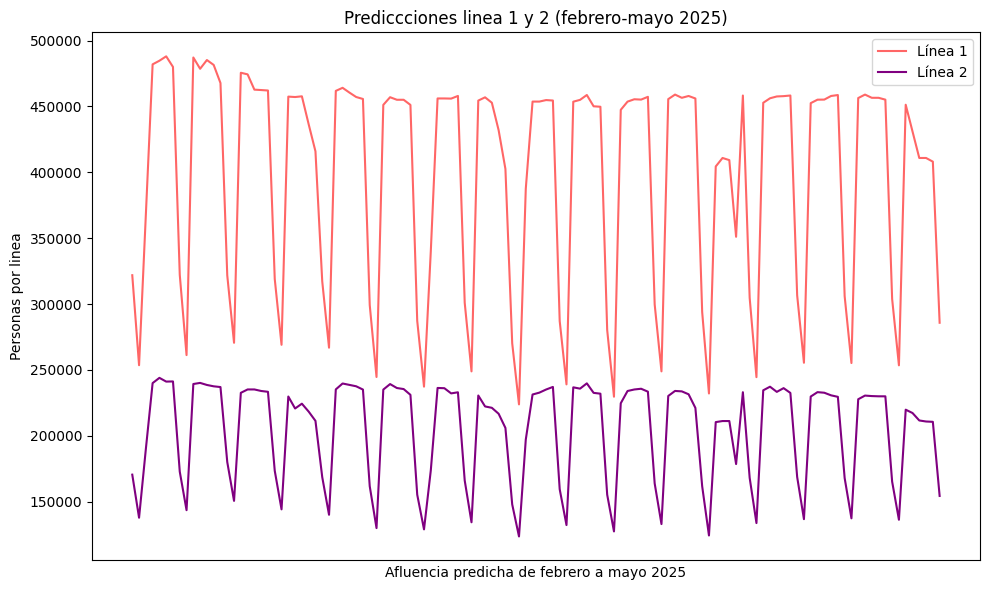

In [460]:
# Gráfico de líneas (1 y 2)
plt.figure(figsize=(10, 6))
plt.plot(df_predicciones_final_linea1_2025['fecha'], df_predicciones_final_linea1_2025['prediccion_afluencia_linea1_2025'], label='Línea 1',color="#FF6666")
plt.plot(df_predicciones_final_linea2_2025['fecha'], df_predicciones_final_linea2_2025['prediccion_afluencia_linea2_2025'], label='Línea 2',color="purple")

# Configuracion el gráfico
plt.title('Prediccciones linea 1 y 2 (febrero-mayo 2025)')#titulo
plt.ylabel('Personas por linea')#etiqueta del eje y
plt.xlabel('Afluencia predicha de febrero a mayo 2025')#etiqueta del eje x
plt.xticks([])  #Se elimina todas las etiquetas del eje X
plt.legend()  # Muestra la leyenda para distinguir entre líneas
plt.tight_layout()  # Ajusta el espacio entre elementos del gráfico
plt.show()#Muestra el grafico

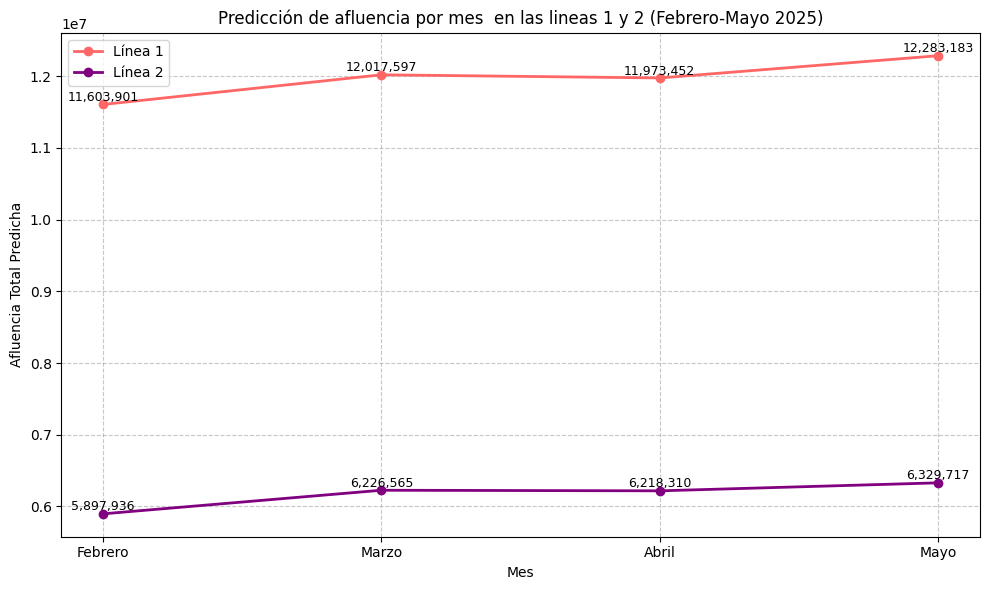

In [461]:
# Orden en base al mes (febrero a mayo 2025)
df_linea1_mes = df_predicciones_final_linea1_2025.groupby('mes')['prediccion_afluencia_linea1_2025'].sum().reset_index()
df_linea2_mes = df_predicciones_final_linea2_2025.groupby('mes')['prediccion_afluencia_linea2_2025'].sum().reset_index()

orden_meses = ['Febrero', 'Marzo', 'Abril', 'Mayo']
df_linea1_mes['mes'] = pd.Categorical(df_linea1_mes['mes'], categories=orden_meses, ordered=True)
df_linea2_mes['mes'] = pd.Categorical(df_linea2_mes['mes'], categories=orden_meses, ordered=True)

# Ordenar por mes
df_linea1_mes = df_linea1_mes.sort_values('mes')
df_linea2_mes = df_linea2_mes.sort_values('mes')

# Tamaño del gráfico
plt.figure(figsize=(10, 6))

# Orden de los meses para eje x
x = range(len(orden_meses))  # Posiciones 0,1,2,3 correspondientes a los meses

# Línea 1
plt.plot(x, df_linea1_mes['prediccion_afluencia_linea1_2025'],
         label='Línea 1',#Etiqueta
         color="#FF6666",  # Color rojo claro
         marker='o',#Circulo  en el mes correspondiente
         linewidth=2)#Grosor de la linea

# Línea 2
plt.plot(x, df_linea2_mes['prediccion_afluencia_linea2_2025'],
         label='Línea 2',#Etiqueta
         color="purple",  # Color morado
         marker='o',#Circulo  en el mes correspondiente
         linewidth=2)#Grosor de la linea

# Etiquetas para mostrar  la afluencia por mes
for i, val in enumerate(df_linea1_mes['prediccion_afluencia_linea1_2025']):
    plt.text(i, val + 5000, f"{val:,.0f}", ha='center', va='bottom', fontsize=9)

for i, val in enumerate(df_linea2_mes['prediccion_afluencia_linea2_2025']):
    plt.text(i, val + 5000, f"{val:,.0f}", ha='center', va='bottom', fontsize=9)

# Configuración del gráfico
plt.title('Predicción de afluencia por mes  en las lineas 1 y 2 (Febrero-Mayo 2025)')
plt.xlabel('Mes')
plt.ylabel('Afluencia Total Predicha')
plt.xticks(x, orden_meses)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()

# Mostrar
plt.show()

In [462]:
# Estadisticos descriptivos para línea 1 y línea 2
descriptivos_linea1_2025 = df_predicciones_final_linea1_2025['prediccion_afluencia_linea1_2025'].describe()
descriptivos_linea2_2025= df_predicciones_final_linea2_2025['prediccion_afluencia_linea2_2025'].describe()


df_descriptivos_pred_2025 = pd.DataFrame({
    'Línea 1': descriptivos_linea1_2025,
    'Línea 2': descriptivos_linea2_2025
}).transpose()

df_descriptivos_pred_2025



,count,mean,std,min,25%,50%,75%,max
Línea 1,120.0,398984.440755,83897.313064,223881.734375,314609.640625,453624.65625,457328.960938,488018.437500
Línea 2,120.0,205604.397721,38415.225213,123662.398438,168800.468750,229834.12500,235110.589844,244014.640625


Para la línea 1 encontramos una media de 398,984 y una mediana de 453,625,con una desviación estándar de 83,897.

Para la línea 2 encontramos una media de 205,604 y una mediana de 229,834, con valores más cercanos al tercer cuartil (235,111). También tenemos una desviación estándar de 38,415.

Tienen algunos días con valores bajos, lo que reduce la media. La desviación estándar, en especial para la Línea 1, muestra la variabilidad en la afluencia,en pocas palabras la prediccion tiene un comporamiento similar a la afluencia de 2024

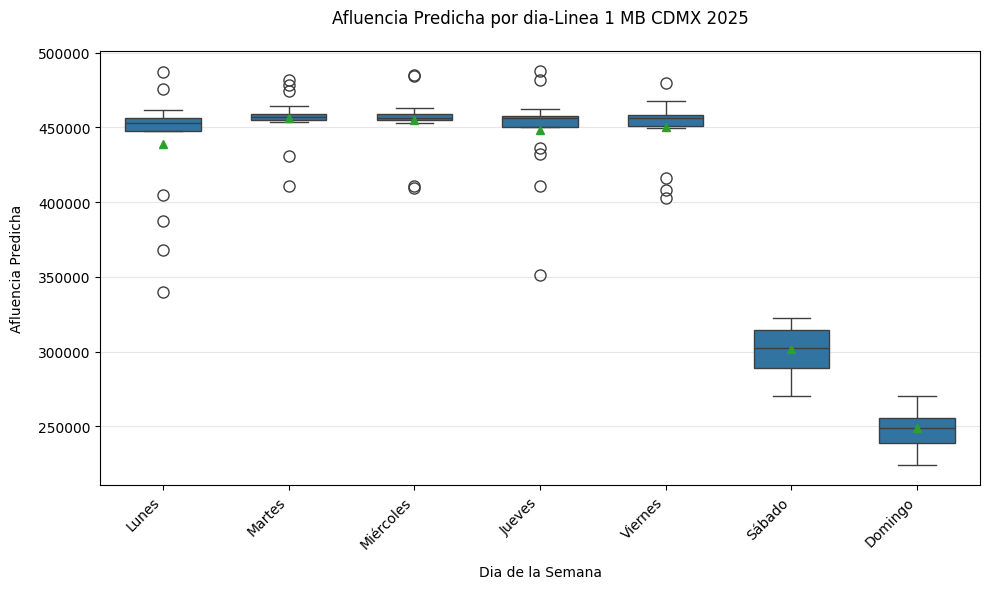

In [463]:
#Grafico de caja y bigotes
# Extraer día de la semana (0=Lunes, 6=Domingo)
df_predicciones_final_linea1_2025['dia_semana'] = pd.to_datetime(df_predicciones_final_linea1_2025['fecha']).dt.dayofweek
df_predicciones_final_linea2_2025['dia_semana'] = pd.to_datetime(df_predicciones_final_linea2_2025['fecha']).dt.dayofweek

# Nombres de días para el eje X
nombres_dias = ['Lunes', 'Martes', 'Miércoles', 'Jueves', 'Viernes', 'Sábado', 'Domingo']

#Grafico
plt.figure(figsize=(10, 6))

sns.boxplot(
    x='dia_semana',
    y='prediccion_afluencia_linea1_2025',
    data=df_predicciones_final_linea1_2025,
    showmeans=True,  # Media con triángulo verde
    flierprops={'marker': 'o', 'markersize': 8},  # Outliers
    width=0.6,

)

# Títulos y etiquetas
plt.title('Afluencia Predicha por dia-Linea 1 MB CDMX 2025', pad=20)
plt.xlabel('Dia de la Semana', labelpad=10)
plt.ylabel('Afluencia Predicha', labelpad=10)
plt.xticks(ticks=range(7), labels=nombres_dias, rotation=45, ha='right')

# Ajustes finales
plt.tight_layout()
plt.grid(axis='y', alpha=0.3)
plt.show()


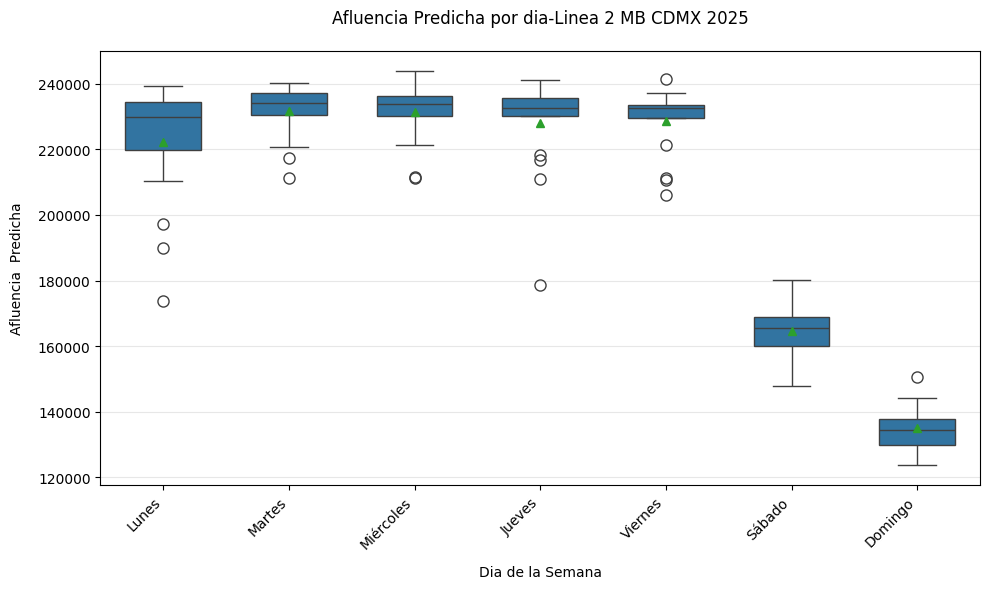

In [464]:
# GRÁFICO PARA LÍNEA 2
plt.figure(figsize=(10, 6))

sns.boxplot(
    x='dia_semana',
    y='prediccion_afluencia_linea2_2025',
    data=df_predicciones_final_linea2_2025,
    showmeans=True,
    flierprops={'marker': 'o', 'markersize': 8},
    width=0.6,
)

plt.title('Afluencia Predicha por dia-Linea 2 MB CDMX 2025', pad=20)
plt.xlabel('Dia de la Semana', labelpad=10)
plt.ylabel('Afluencia  Predicha', labelpad=10)
plt.xticks(ticks=range(7), labels=nombres_dias, rotation=45, ha='right')

plt.tight_layout()
plt.grid(axis='y', alpha=0.3)
plt.show()

#METRICAS Y EVALUACION
La evaluacion se hara con los datos reales de febrero a abril 2025 debido a que son los disponibles al momento de elaborar el proyecto

#EVALUACION PARCIAL LINEA 1


#Cargada de datos linea 1

In [465]:
#Datos de la afluencia de la linea 1
#datos_reales_afluencia_linea1_2025 = pd.read_csv("/content/drive/My Drive/Ciencia de datos/Proyecto final/afluenciareal2025/linea1afluenciareal2025/linea1datosreal2025.csv")
datos_reales_afluencia_linea1_2025 = pd.read_csv("linea1datosreal2025.csv")
datos_reales_afluencia_linea1_2025
datos_reales_afluencia_linea1_2025['fecha'] = pd.to_datetime(datos_reales_afluencia_linea1_2025['fecha'])
print(datos_reales_afluencia_linea1_2025.tail())


         fecha    mes  anio    linea  tipo_pago  afluencia temporal_fecha  \
173 2025-04-28  Abril  2025  Línea 1  Gratuidad      34814        2025-04   
174 2025-04-29  Abril  2025  Línea 1    Prepago     426780        2025-04   
175 2025-04-29  Abril  2025  Línea 1  Gratuidad      31382        2025-04   
176 2025-04-30  Abril  2025  Línea 1    Prepago     498775        2025-04   
177 2025-04-30  Abril  2025  Línea 1  Gratuidad      25793        2025-04   

     ..anio_fecha  
173          2025  
174          2025  
175          2025  
176          2025  
177          2025  


In [466]:
#Se aplica la funcion procesar_afluencia para unir los datos
#Linea 1
datos_reales_linea1_2025_procesado = procesar_afluencia(datos_reales_afluencia_linea1_2025)
#Se renombra la columna de afluencia total para mayor claridad
datos_reales_linea1_2025_procesado.rename(columns={'afluencia_total': 'afluenciareal_linea1'}, inplace=True)
print(datos_reales_linea1_2025_procesado.head())
print(datos_reales_linea1_2025_procesado.tail())


       fecha    linea      mes  anio temporal_fecha  ..anio_fecha  \
0 2025-02-01  Línea 1  Febrero  2025        2025-02          2025   
1 2025-02-02  Línea 1  Febrero  2025        2025-02          2025   
2 2025-02-03  Línea 1  Febrero  2025        2025-02          2025   
3 2025-02-04  Línea 1  Febrero  2025        2025-02          2025   
4 2025-02-05  Línea 1  Febrero  2025        2025-02          2025   

   afluenciareal_linea1  
0                329171  
1                223304  
2                184923  
3                520816  
4                522233  
        fecha    linea    mes  anio temporal_fecha  ..anio_fecha  \
84 2025-04-26  Línea 1  Abril  2025        2025-04          2025   
85 2025-04-27  Línea 1  Abril  2025        2025-04          2025   
86 2025-04-28  Línea 1  Abril  2025        2025-04          2025   
87 2025-04-29  Línea 1  Abril  2025        2025-04          2025   
88 2025-04-30  Línea 1  Abril  2025        2025-04          2025   

    afluenciareal_li

#Comparacion de los datos (predicho vs real) Linea 1 febrero-abril 2025

In [467]:
#Seleccion de los valores de febrero a abril predichos para 2025
df_feb_abr_predicho_2025_linea1 = df_predicciones_final_linea1_2025[(df_predicciones_final_linea1_2025['fecha'].dt.month >= 2) & (df_predicciones_final_linea1_2025['fecha'].dt.month <= 4)]
print(df_feb_abr_predicho_2025_linea1.tail())


        fecha  prediccion_afluencia_linea1_2025    mes  dia_semana
84 2025-04-26                     294024.156250  Abril           5
85 2025-04-27                     232150.765625  Abril           6
86 2025-04-28                     404448.968750  Abril           0
87 2025-04-29                     410885.593750  Abril           1
88 2025-04-30                     409254.562500  Abril           2


In [468]:


# Seleccionar columnas específicas de df
columnas_predicciones = ['prediccion_afluencia_linea1_2025']
columnas_reales = ["fecha","linea","mes","anio","afluenciareal_linea1"]

# Df con las columnas que se quieren para la linea 1
def_pred_selec_linea1 = df_feb_abr_predicho_2025_linea1[columnas_predicciones]
df_real_selec_linea1 = datos_reales_linea1_2025_procesado[columnas_reales]

# Se unen horizontalmente en base a las columnas
df_unido_linea1_2025= pd.concat([ df_real_selec_linea1,def_pred_selec_linea1], axis=1)


print(df_unido_linea1_2025.head())
print(df_unido_linea1_2025.tail())

       fecha    linea      mes  anio  afluenciareal_linea1  \
0 2025-02-01  Línea 1  Febrero  2025                329171   
1 2025-02-02  Línea 1  Febrero  2025                223304   
2 2025-02-03  Línea 1  Febrero  2025                184923   
3 2025-02-04  Línea 1  Febrero  2025                520816   
4 2025-02-05  Línea 1  Febrero  2025                522233   

   prediccion_afluencia_linea1_2025  
0                      321913.78125  
1                      253608.62500  
2                      367669.68750  
3                      481943.25000  
4                      484684.87500  
        fecha    linea    mes  anio  afluenciareal_linea1  \
84 2025-04-26  Línea 1  Abril  2025                334855   
85 2025-04-27  Línea 1  Abril  2025                250140   
86 2025-04-28  Línea 1  Abril  2025                427313   
87 2025-04-29  Línea 1  Abril  2025                458162   
88 2025-04-30  Línea 1  Abril  2025                524568   

    prediccion_afluencia_linea1_

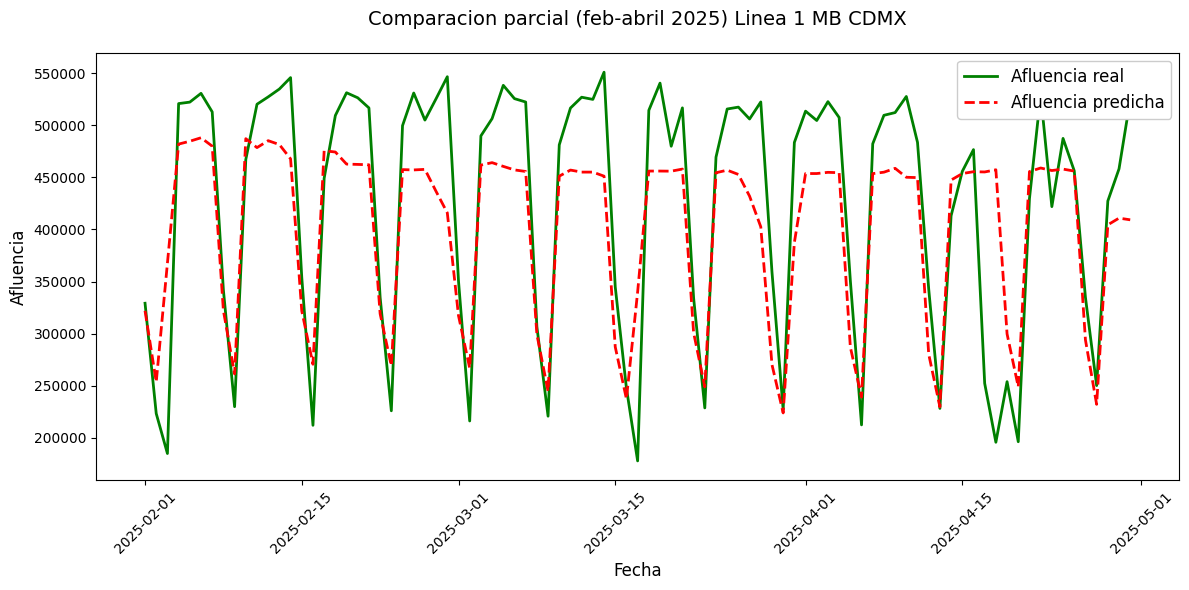

In [469]:


# Configuracion del grafico
plt.style.use('default')  # Estilo basico
plt.figure(figsize=(12, 6)) #Tamaño del grafico

# Gráfico de lineas para comparar la afluencia
plt.plot(df_unido_linea1_2025['fecha'],
         df_unido_linea1_2025['afluenciareal_linea1'],
         label='Afluencia real',
         color='green',
         linewidth=2)

plt.plot(df_unido_linea1_2025['fecha'],
         df_unido_linea1_2025['prediccion_afluencia_linea1_2025'],
         label='Afluencia predicha',
         color='red',
         linestyle='--',
         linewidth=2)

#Titulos
plt.title('Comparacion parcial (feb-abril 2025) Linea 1 MB CDMX', fontsize=14, pad=20)
plt.xlabel('Fecha', fontsize=12)
plt.ylabel('Afluencia', fontsize=12)
plt.xticks(rotation=45)



# Mejora la posicion
plt.legend(fontsize=12, framealpha=1, loc='upper right')

# Ajusta margenes
plt.tight_layout()

# Muestra el grafico
plt.show()

#Metricas para la linea 1

In [470]:
# Datos reales y predichos
real_linea1 = df_unido_linea1_2025['afluenciareal_linea1']
predicho_linea1 = df_unido_linea1_2025['prediccion_afluencia_linea1_2025']

# Cálculo de métricas
rmse = np.sqrt(mean_squared_error(real_linea1, predicho_linea1))
mae = mean_absolute_error(real_linea1, predicho_linea1)
mape = np.mean(np.abs((real_linea1[real_linea1 != 0] - predicho_linea1[real_linea1 != 0]) / real_linea1[real_linea1 != 0])) * 100

# Metricas
print("\nMétricas para Línea 1:")
print(f"- RMSE: {rmse:.2f} pasajeros")
print(f"- MAE: {mae:.2f} pasajeros")
print(f"- MAPE: {mape:.2f}%")


Métricas para Línea 1:
- RMSE: 69037.50 pasajeros
- MAE: 54585.69 pasajeros
- MAPE: 15.10%


#EVALUACION PARCIAL LINEA 2

#Cargada de datos linea 2

In [471]:
#Datos de la afluencia de la linea 1
#datos_reales_afluencia_linea2_2025 = pd.read_csv("/content/drive/My Drive/Ciencia de datos/Proyecto final/afluenciareal2025/linea2afluenciareal2025/linea2datosreal2025.csv")
datos_reales_afluencia_linea2_2025 = pd.read_csv("linea2datosreal2025.csv")
datos_reales_afluencia_linea2_2025['fecha'] = pd.to_datetime(datos_reales_afluencia_linea2_2025['fecha'])
print(datos_reales_afluencia_linea2_2025.tail())

         fecha    mes  anio    linea  tipo_pago  afluencia temporal_fecha  \
173 2025-04-28  Abril  2025  Línea 2  Gratuidad      13649        2025-04   
174 2025-04-29  Abril  2025  Línea 2    Prepago     217146        2025-04   
175 2025-04-29  Abril  2025  Línea 2  Gratuidad      14826        2025-04   
176 2025-04-30  Abril  2025  Línea 2    Prepago     227612        2025-04   
177 2025-04-30  Abril  2025  Línea 2  Gratuidad      14829        2025-04   

     ..anio_fecha  
173          2025  
174          2025  
175          2025  
176          2025  
177          2025  


In [472]:
#Se aplica la funcion procesar_afluencia para unir los datos
#Linea 2
datos_reales_linea2_2025_procesado = procesar_afluencia(datos_reales_afluencia_linea2_2025)
#Se renombra la columna de afluencia total para mayor claridad
datos_reales_linea2_2025_procesado.rename(columns={'afluencia_total': 'afluenciareal_linea2'}, inplace=True)
print(datos_reales_linea2_2025_procesado.head())
print(datos_reales_linea1_2025_procesado.tail())


       fecha    linea      mes  anio temporal_fecha  ..anio_fecha  \
0 2025-02-01  Línea 2  Febrero  2025        2025-02          2025   
1 2025-02-02  Línea 2  Febrero  2025        2025-02          2025   
2 2025-02-03  Línea 2  Febrero  2025        2025-02          2025   
3 2025-02-04  Línea 2  Febrero  2025        2025-02          2025   
4 2025-02-05  Línea 2  Febrero  2025        2025-02          2025   

   afluenciareal_linea2  
0                154543  
1                 94250  
2                106373  
3                221724  
4                225255  
        fecha    linea    mes  anio temporal_fecha  ..anio_fecha  \
84 2025-04-26  Línea 1  Abril  2025        2025-04          2025   
85 2025-04-27  Línea 1  Abril  2025        2025-04          2025   
86 2025-04-28  Línea 1  Abril  2025        2025-04          2025   
87 2025-04-29  Línea 1  Abril  2025        2025-04          2025   
88 2025-04-30  Línea 1  Abril  2025        2025-04          2025   

    afluenciareal_li

#Comparacion de los datos (predicho vs real) Linea 2 febrero-abril 2025

In [473]:
#Seleccion de los valores de febrero a abril predichos para 2025
df_feb_abr_predicho_2025_linea2= df_predicciones_final_linea2_2025[(df_predicciones_final_linea2_2025['fecha'].dt.month >= 2) & (df_predicciones_final_linea2_2025['fecha'].dt.month <= 4)]
print(df_feb_abr_predicho_2025_linea2.head())
print(df_feb_abr_predicho_2025_linea2.tail())

       fecha  prediccion_afluencia_linea2_2025      mes  dia_semana
0 2025-02-01                     170563.921875  Febrero           5
1 2025-02-02                     137867.546875  Febrero           6
2 2025-02-03                     189929.453125  Febrero           0
3 2025-02-04                     240034.015625  Febrero           1
4 2025-02-05                     244014.640625  Febrero           2
        fecha  prediccion_afluencia_linea2_2025    mes  dia_semana
84 2025-04-26                     161789.625000  Abril           5
85 2025-04-27                     124390.890625  Abril           6
86 2025-04-28                     210436.328125  Abril           0
87 2025-04-29                     211239.718750  Abril           1
88 2025-04-30                     211239.718750  Abril           2


In [474]:
# Seleccionar columnas específicas de df
col_predic_linea2_2025 = ['prediccion_afluencia_linea2_2025']  # Reemplaza con las columnas que quieres del df_predicciones
columnas_reales_linea2_2025 = ["fecha","linea","mes","anio","afluenciareal_linea2"]        # Reemplaza con las columnas que quieres del df_reales

# Df con las columnas que se quieren para la linea 2
def_pred_selec_linea2 = df_feb_abr_predicho_2025_linea2[col_predic_linea2_2025]
df_real_selec_linea2 = datos_reales_linea2_2025_procesado[columnas_reales_linea2_2025]

# Se unen horizontalmente en base a las columnas
df_unido_linea2_2025= pd.concat([ df_real_selec_linea2,def_pred_selec_linea2], axis=1)


print(df_unido_linea2_2025.head())
print(df_unido_linea2_2025.tail())
print(df_unido_linea2_2025.columns)

       fecha    linea      mes  anio  afluenciareal_linea2  \
0 2025-02-01  Línea 2  Febrero  2025                154543   
1 2025-02-02  Línea 2  Febrero  2025                 94250   
2 2025-02-03  Línea 2  Febrero  2025                106373   
3 2025-02-04  Línea 2  Febrero  2025                221724   
4 2025-02-05  Línea 2  Febrero  2025                225255   

   prediccion_afluencia_linea2_2025  
0                     170563.921875  
1                     137867.546875  
2                     189929.453125  
3                     240034.015625  
4                     244014.640625  
        fecha    linea    mes  anio  afluenciareal_linea2  \
84 2025-04-26  Línea 2  Abril  2025                148992   
85 2025-04-27  Línea 2  Abril  2025                 99702   
86 2025-04-28  Línea 2  Abril  2025                229300   
87 2025-04-29  Línea 2  Abril  2025                231972   
88 2025-04-30  Línea 2  Abril  2025                242441   

    prediccion_afluencia_linea2_

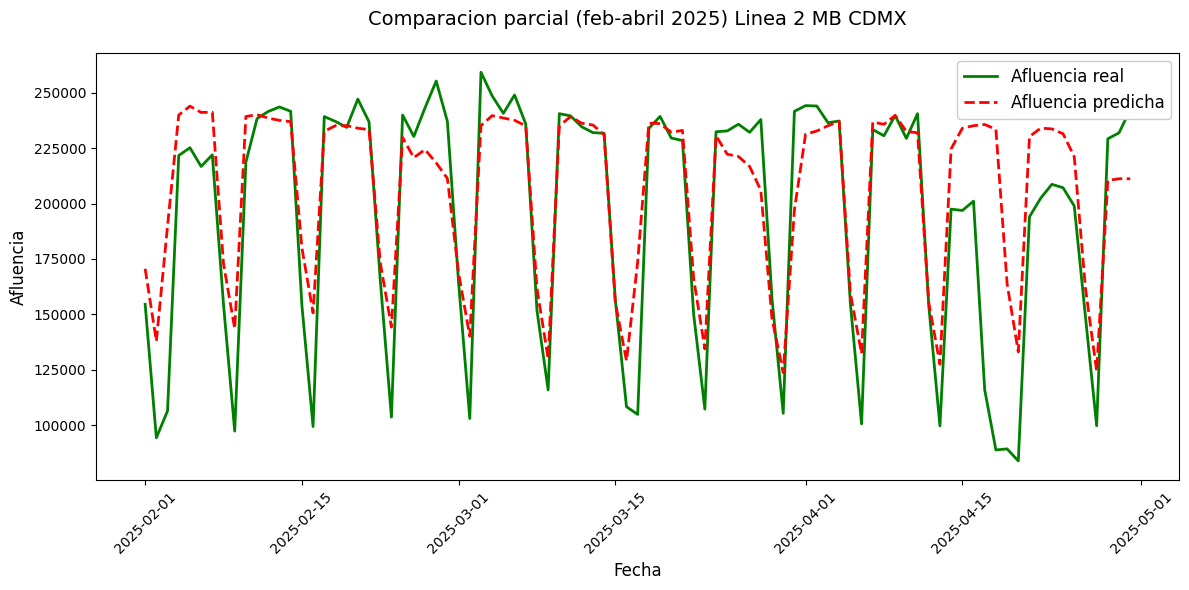

In [475]:

# Configuracion del grafico
plt.style.use('default')  # Estilo basico
plt.figure(figsize=(12, 6)) #Tamaño del grafico

# Gráfico de lineas para comparar la afluencia
plt.plot(df_unido_linea2_2025['fecha'],
         df_unido_linea2_2025['afluenciareal_linea2'],
         label='Afluencia real',
         color='green',
         linewidth=2)

plt.plot(df_unido_linea2_2025['fecha'],
         df_unido_linea2_2025['prediccion_afluencia_linea2_2025'],
         label='Afluencia predicha',
         color='red',
         linestyle='--',
         linewidth=2)

#Titulos
plt.title('Comparacion parcial (feb-abril 2025) Linea 2 MB CDMX', fontsize=14, pad=20)
plt.xlabel('Fecha', fontsize=12)
plt.ylabel('Afluencia', fontsize=12)
plt.xticks(rotation=45)



# Mejora la posicion
plt.legend(fontsize=12, framealpha=1, loc='upper right')

# Ajusta margenes
plt.tight_layout()

# Muestra el grafico
plt.show()

#Metricas para la linea 2

In [476]:
# Datos reales y predichos para la linea 2
real_linea2 = df_unido_linea2_2025['afluenciareal_linea2']
predicho_linea2 = df_unido_linea2_2025['prediccion_afluencia_linea2_2025']

# Cálculo de métricas
rmse = np.sqrt(mean_squared_error(real_linea2, predicho_linea2))
mae = mean_absolute_error(real_linea2, predicho_linea2)
mape = np.mean(np.abs((real_linea2[real_linea2 != 0] - predicho_linea2[real_linea2 != 0]) / real_linea2[real_linea2 != 0])) * 100

#Metricas
print("\nMétricas para Línea 2:")
print(f"- RMSE: {rmse:.2f} pasajeros")
print(f"- MAE: {mae:.2f} pasajeros")
print(f"- MAPE: {mape:.2f}%")


Métricas para Línea 2:
- RMSE: 31753.33 pasajeros
- MAE: 20691.52 pasajeros
- MAPE: 15.36%
